In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.neighbors import LSHForest
import pandas as pd
import statsmodels.api as sm
from pandas import Series, DataFrame
from sklearn import datasets, svm
import  scipy.stats as stats
from sklearn.neighbors import BallTree
import scipy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.cluster import KMeans
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import hdbscan
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from scipy import interpolate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import  cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from scipy.sparse import hstack
from sklearn.feature_selection import chi2
from scipy.stats import mode
import time
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import pairwise_kernels
import re
from nltk.corpus import stopwords
from dateutil.parser import parse
import nltk,string
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
import pylab as pl
from math import log
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import ast
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np
import itertools
from pandas.io.json import json_normalize
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
import sklearn.cluster as cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
import time
%matplotlib inline
style.use("ggplot")
sns.set()

### ANALYZING DATA IN FILE(PEinfo)

In [2]:
# read the entire file into a python array
with open('training_set_dedup', 'r') as f:
    data_json_str = "[" + ','.join(map(lambda x: x.rstrip(), f.readlines())) + "]" 


In [3]:
# now, load it into pandas
data_df = pd.read_json(data_json_str, orient='columns')

### Decompose Results Section (into peinfo and sha256)

In [4]:
data_sha_peinfo = data_df['results'].apply(pd.Series)['peinfo']
# data_test_sha_peinfo = data_test_df['peinfo'].apply(pd.Series)

In [5]:
train_df = pd.concat((data_df , data_sha_peinfo),axis=1).drop(['results'], 1)

In [6]:
sha_df_mal = train_df.loc[train_df['label'] == "malicious"]['sha256'].astype(str)
sha_df_benign = train_df.loc[train_df['label'] == "benign"]['sha256'].astype(str)
sha_df_mal= sha_df_mal.reset_index(drop=True)
sha_df_benign = sha_df_benign.reset_index(drop=True)

### Decompose peinfo(Make keys as features)

In [7]:
data_peinfo = train_df['peinfo'].apply(pd.Series)

In [8]:
data_total_train = pd.concat((train_df , data_peinfo),axis=1).drop(['peinfo'],1)

### Mapping beign to 0 and malicious to 1

In [9]:
mymap_cat = {'benign': 0, 'malicious': 1}
mymap_version_var = {'nan': 0, '[]': 1}
data_total_train['label'] =data_total_train['label'].map(mymap_cat).astype(int)
data_total_train['version_var'] =data_total_train['version_var'].astype(str).map(mymap_version_var).astype(int)


In [10]:
new_train_features = data_total_train.drop(['sha256','imphash','pehash','timestamp'],1)


### Decompose rich_header (Analyze checksum	,sha256,	values_parsed	,values_raw)

In [11]:
data_rich_header = data_total_train['rich_header'].apply(pd.Series)[['values_parsed','values_raw','checksum']]

In [12]:
data_rich_header = data_rich_header.rename(columns = {'values_parsed':'peinfoHeader_values_parsed','values_raw':'peinfoHeader_values_raw','checksum':'peinfoHeader_checksum'})

In [13]:
data_train = pd.concat((data_total_train , data_rich_header),axis=1).drop(['rich_header'],1).fillna(0)

In [14]:
new_train_features['peinfoHeader_checksum'] = data_train['peinfoHeader_checksum'].fillna(0)

### Basic preprocessing convert (keys) Unicode to string  and dict to list 

In [15]:
def convert(data):
    if isinstance(data, basestring):
        return str(data)
    elif isinstance(data, collections.Mapping):
        return dict(map(convert, data.iteritems()))
    elif isinstance(data, collections.Iterable):
        return type(data)(map(convert, data))
    else:
        return data

In [16]:
def dicttolistOHE(df_col):
    XFeatures = []
    for i in range(len(df_col)):
        XFeatures.append([])
        result = collections.defaultdict(list)
        if isinstance(df_col[i],list):
            for d in df_col[i]:
                for k, v in d.items():
                    result[k].append(v)
            XFeatures[i].append(dict(result))
        else:
            XFeatures[i].append(0)
    return XFeatures



### Decompose Debug File

In [17]:
# data_debug_train = dicttolistOHE(data_total_train['debug'])
#data_test_rich_header = test_df['rich_header'].apply(pd.Series)[['values_parsed','values_raw','checksum']]

### Decompose thread_local_storage

In [18]:
Xthread_local_storage = dicttolistOHE(data_train['thread_local_storage'])


In [19]:
data_train['Xthread_local_storage']  = [val for sublist in Xthread_local_storage for val in sublist]

In [20]:
data_thread  = data_train['Xthread_local_storage'].apply(pd.Series).drop([0],1)


In [21]:
data_thread = data_thread.rename(columns = {"Callback Function":"Callback_Function",'TLS Callback Function':'TLS_Callback_Function'})


### Preprocessing rich_header( peinfoHeader_values_parsed &	peinfoHeader_values_raw)

In [22]:
XFeatures = dicttolistOHE(data_train['peinfoHeader_values_parsed'])


In [23]:
data_train['peinfoHeader_values_parsed']  = [val for sublist in XFeatures for val in sublist]

In [24]:
data_new  = data_train['peinfoHeader_values_parsed'].apply(pd.Series)

In [25]:
data_valuesparsed = data_new.drop([0],1)

### One Hot Encoding Rich Header

In [26]:
def getOHE(col_train):
    train_encoded = pd.get_dummies(col_train.astype(str))
    return train_encoded

In [27]:
def limitedOHEtrain(col,threshold,name):
    values = pd.Series(col).astype(str)
    counts_train = col.astype(str).value_counts()
    mask_id = values.isin(counts_train[counts_train > threshold].index)
    values[~mask_id] = "-"+ name
    new_dataOHE = pd.get_dummies(values)
    return new_dataOHE



def selectBestFeaturesUnivariate(X,y,k_features):
    features = SelectKBest(chi2,k=k_features)
    X_k_features = features.fit_transform(X, y)
    top_ranked_features = sorted(enumerate(features.scores_),key=lambda x:x[1], reverse=True)[:k_features]
    return X_k_features

In [28]:
header_times_used_OHE= getOHE(data_valuesparsed.times_used)
header_version_OHE= getOHE(data_valuesparsed.version)
header_id_OHE = getOHE(data_valuesparsed.id)

In [29]:
header_valuesraw_OHE = limitedOHEtrain(data_train.peinfoHeader_values_raw,5,"values_raw")

In [30]:
header_times_used_sel = selectBestFeaturesUnivariate(header_times_used_OHE,data_train["label"],500)

In [31]:
header_version_sel = selectBestFeaturesUnivariate(header_version_OHE,data_train["label"],500)

In [32]:
header_id_sel = selectBestFeaturesUnivariate(header_id_OHE,data_train["label"],500)


### One Hot Encoding  Debug

In [33]:
data_debug_train = dicttolistOHE(data_total_train['debug'])

data_train['debug']  = [val for sublist in data_debug_train for val in sublist]

data_debug = data_train['debug'].apply(pd.Series).drop([0],1).fillna(0)

data_debug['DebugAg_train'] = data_debug['DebugAge']
data_debug.loc[data_debug['DebugAge'] == 0, 'DebugAg_train'] =[[0]]

### One Hot Encoding of thread local storage

In [34]:
mymap_debugSig = {'0': 0, "[u'RSDS']":1,"[u'NB10']":2}
# data_debug_GUID_OHE ,data_debug_test_GUID_OHE = limitedOHEtrain(data_debug.DebugGUID ,data_debug_test.DebugGUID,5,"debug_GUID")

In [35]:
thread_local_storage_OHE  = getOHE(data_thread.Callback_Function)

In [36]:
thread_local_storagetls_OHE = getOHE(data_thread.TLS_Callback_Function)

In [37]:
debug_age_train= [val for sublist in data_debug.DebugAg_train for val in sublist ]

# data_debug_DebugPath_OHE ,data_debug_DebugPath_test_OHE = limitedOHEtrain(data_debug.DebugPath ,data_debug_test.DebugPath,5,"debug_DebugPath")
debugSig_train= data_debug["DebugSig"].astype(str).map(mymap_debugSig)

# data_debug_MinorVersion_OHE ,data_debug_MinorVersion_test_OHE =getOHE(data_debug.MinorVersion ,data_debug_test.MinorVersion)
# data_debug_MajorVersion_OHE ,data_debug_MajorVersion_test_OHE =getOHE(data_debug.MajorVersion ,data_debug_test.MajorVersion)
# data_debug_Pointer_OHE ,data_debug_Pointer_test_OHE = limitedOHEtrain(data_debug.PointerToRawData ,data_debug_test.PointerToRawData,5,"debug_pointer")
# data_debug_SizeOfData_OHE ,data_debug_SizeOfData_test_OHE = limitedOHEtrain(data_debug.SizeOfData ,data_debug_test.SizeOfData,5,"SizeOfData")
# data_debug_Type_OHE ,data_debug_Type_test_OHE = limitedOHEtrain(data_debug.Type ,data_debug_test.Type,5,"debug_Type")
# data_debug_result_OHE ,data_debug_result_test_OHE = limitedOHEtrain(data_debug.result ,data_debug_test.result,5,"result")
# data_debug_subtype_OHE ,data_debug_subtype_test_OHE =getOHE(data_debug.subtype ,data_debug_test.subtype)


In [38]:
frames = [header_times_used_OHE, header_version_OHE, header_id_OHE, header_valuesraw_OHE, thread_local_storage_OHE, thread_local_storagetls_OHE, pd.DataFrame(data_total_train.version_var),pd.DataFrame(data_total_train['label'])]


In [39]:
headertrain_OHE = pd.concat(frames, axis=1)


### Number of Pe_Sections

In [40]:
data_train['pe_sections'] = data_train['pe_sections'].fillna('[0]')

In [41]:
number_pesection = []
for i in range(len(data_train['pe_sections'])):
    number_pesection.append([])
    if isinstance(data_train['pe_sections'][i],list):
#         print i , len(data_train['pe_sections'][i])
        number_pesection[i].append(len(data_train['pe_sections'][i]))
    else:
        number_pesection[i].append(0)
        

In [42]:
data_train['number_pesection'] = [val for sublist in number_pesection for val in sublist]

In [43]:
headertrain_OHE = pd.concat([pd.DataFrame(headertrain_OHE),data_train['peinfoHeader_checksum'].astype('float32') ] ,axis=1)

### Mean,Median,Mode Entropy per Section

In [44]:
data_train['peinfoHeader_pesection']  = dicttolistOHE(data_train['pe_sections'])

In [45]:
peinfoHeader_pesection = data_train['peinfoHeader_pesection'].apply(pd.Series)

In [46]:
peinfoHeaderSection_updated  = peinfoHeader_pesection[0].apply(pd.Series).drop([0,'md5','section_name','virt_address'],1)

In [47]:
peinfoHeaderSection_updated = peinfoHeaderSection_updated.rename(columns = {'size':'peinfoHeader_size'})

In [48]:
pesection_entropy_OHE = limitedOHEtrain(peinfoHeaderSection_updated.entropy,5,"entropy")
pesection_size_OHE = limitedOHEtrain(peinfoHeaderSection_updated.peinfoHeader_size,5,"size")
pesection_virtsize_OHE = limitedOHEtrain(peinfoHeaderSection_updated.virt_size,5,"vsize")#pesection_testentropy_OHE = limitedOHE(peinfoHeaderSection_testupdated.entropy,5,"entropy")
# header_times_used_OHE = limitedOHE(data_valuesparsed.times_used,1)
# header_testtimes_used_OHE = limitedOHE(data_test_valuesparsed.times_used,10)
# header_version_OHE = limitedOHE(data_valuesparsed.version,1)
# header_testversion_OHE = limitedOHE(data_test_valuesparsed.version,10)
# header_valuesraw_OHE= limitedOHE(data_train.peinfoHeader_values_raw,1)
# header_valuesrawtest_OHE= limitedOHE(data_test.peinfoHeader_values_raw,10)

In [49]:
headertrain_OHE = pd.concat([headertrain_OHE,pesection_entropy_OHE ,pesection_size_OHE,pesection_virtsize_OHE] ,axis=1)

In [50]:
subset_df_benign = headertrain_OHE.loc[data_train['label'] == 0]
subset_df_mal = headertrain_OHE.loc[data_train['label'] == 1]

In [51]:
headertrain_OHE_sparse = pd.concat([headertrain_OHE ] ,axis=1).as_matrix()
headertrain_OHE_benign_sparse = pd.concat([subset_df_benign ] ,axis=1).drop(['label'],1).as_matrix()
headertrain_OHE_mal_sparse = pd.concat([subset_df_mal ] ,axis=1).drop(['label'],1).as_matrix()


In [52]:
headertrain_OHE_sparse_mat = scipy.sparse.csr_matrix(headertrain_OHE_sparse)
headertrain_OHE_benign_sparse_mat = scipy.sparse.csr_matrix(headertrain_OHE_benign_sparse)
headertrain_OHE_mal_sparse_mat = scipy.sparse.csr_matrix(headertrain_OHE_mal_sparse)


In [53]:
headertrain_OHE_benign_sparse_mat

<4754x8652 sparse matrix of type '<type 'numpy.float64'>'
	with 51726 stored elements in Compressed Sparse Row format>

In [54]:
headertrain_OHE_mal_sparse_mat

<5000x8652 sparse matrix of type '<type 'numpy.float64'>'
	with 50892 stored elements in Compressed Sparse Row format>

### N-gram of Import Section and version_info

In [55]:
XExports = dicttolistOHE(data_train['exports'])
XImports = dicttolistOHE(data_train['imports'])
XVersionInfo =  dicttolistOHE(data_train['version_info'])

In [56]:
data_train['pe_allexports'] = [val for sublist in XExports for val in sublist]
data_train['pe_version_info'] =  [val for sublist in XVersionInfo for val in sublist]
data_train['pe_imports'] =  [val for sublist in XImports for val in sublist]
# data_test['pe_allexports'] = [val for sublist in XExports_test for val in sublist]
# data_test['pe_version_info'] =  [val for sublist in XVersionInfo_test for val in sublist]
# data_test['pe_imports'] =  [val for sublist in XImports_test for val in sublist]
# data_test['error'] =  data_total_train['error'].fillna(0)



In [57]:
data_train['function_exports'] = data_train['pe_allexports'].apply(pd.Series)['function'].fillna('0').astype(str)

### Ngram(Textual Features) 

In [58]:
data_train['version_info_key'] = data_train['pe_version_info'].apply(pd.Series)[['key']].fillna(0).astype(str)
data_train['version_info_value'] = data_train['pe_version_info'].apply(pd.Series)[['value']].fillna(0).astype(str)
data_train['pe_imports_dll'] = data_train['pe_imports'].apply(pd.Series)[['dll']].fillna(0).astype(str)
data_train['pe_imports_function'] = data_train['pe_imports'].apply(pd.Series)[['function']].fillna(0).astype(str)

In [59]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english')

In [60]:
tfidf_matrix_version_info =  vectorizer.fit_transform(data_train['version_info_key']).tocsr()

In [61]:
tfidf_matrix_version_value = vectorizer.fit_transform(data_train['version_info_value']).tocsr()
# tfidf_testmatrix_version_value = vectorizer.transform(data_test['version_info_value']).tocsr()

In [62]:
tfidf_matrix_pe_imports_dll = vectorizer.fit_transform(data_train['pe_imports_dll']).tocsr()
# tfidf_testmatrix_pe_imports_dll = vectorizer.transform(data_test['pe_imports_dll']).tocsr()

In [63]:

tfidf_matrix_pe_imports_function  = vectorizer.fit_transform(data_train['pe_imports_function']).tocsr()
# tfidf_testmatrix_pe_imports_function  = vectorizer.transform(data_test['pe_imports_function']).tocsr()

In [64]:
tfidf_matrix_exports  = vectorizer.fit_transform(data_train['function_exports']).tocsr()
# tfidf_testmatrix_exports  = vectorizer.transform(data_test['function_exports']).tocsr()

In [65]:
tfidf_matrix_pe_error  = vectorizer.fit_transform(data_train['error'].astype(str)).tocsr()
# tfidf_testmatrix_error  = vectorizer.transform(data_test['error'].astype(str)).tocsr()

In [66]:
total_textual_features_ngram = hstack((tfidf_matrix_version_info, tfidf_matrix_version_value,tfidf_matrix_pe_imports_dll,tfidf_matrix_pe_imports_function,tfidf_matrix_pe_error)).tocsr()
# total_textualtest_features_test = hstack((tfidf_testmatrix_version_info, tfidf_testmatrix_version_value,tfidf_testmatrix_pe_imports_dll,tfidf_testmatrix_pe_imports_function,tfidf_testmatrix_error)).tocsr()

In [67]:
mal_list = list(subset_df_mal.index.values)
benign_list = list(subset_df_benign.index.values)

In [68]:
total_textual_features_mal = total_textual_features_ngram[mal_list][:]
total_textual_features_ben = total_textual_features_ngram[benign_list][:]

In [69]:
total_textual_features = hstack((total_textual_features_ngram,headertrain_OHE_sparse_mat))
total_textual_features_mal = hstack((total_textual_features_mal,headertrain_OHE_mal_sparse))
total_textual_features_ben = hstack((total_textual_features_ben,headertrain_OHE_benign_sparse))


### Analyzing ObjDump File

In [70]:
chunksize = 10000
mal_data = pd.read_csv('malicious_objdump_40000',sep = '\t', dtype = None,  chunksize=chunksize, iterator=True,names = ["Obj_dump"])
for df in mal_data:
    df_opcode_mal = df['Obj_dump'].fillna(0).apply(json.loads).apply(pd.Series)

In [71]:
df_objdump = df_opcode_mal['objdump'].apply(pd.Series)
df_sha256 = df_opcode_mal['sha256']
df_malign = pd.concat([df_objdump,df_sha256], axis=1)

In [72]:
for df in pd.read_csv('benign_objdump_40000',sep = '\t', dtype = None,  chunksize=chunksize, iterator=True,names = ["Obj_dump"]):    
    df_opcode_benign = df['Obj_dump'].fillna(0).apply(json.loads).apply(pd.Series)

### Decomposing Obj_dump

In [73]:
df_objdumpb = df_opcode_benign['objdump'].apply(pd.Series)
df_sha256b = df_opcode_benign['sha256']
df_benign = pd.concat([df_objdumpb,df_sha256b], axis=1)

In [74]:
df_opcodes_malicious = df_malign['sections'].apply(pd.Series)['.text']
df_opcodes_benign = df_benign['sections'].apply(pd.Series)['.text']

In [75]:
flags_malicious = df_opcodes_malicious.apply(pd.Series)[['flags','name','truncated']].fillna('0').rename(columns = {'flags':'section_flags','name':'section_name','truncated':'section_truncated'})
flags_benign = df_opcodes_benign.apply(pd.Series)[['flags','name','truncated']].fillna('0').rename(columns = {'flags':'section_flags','name':'section_name','truncated':'section_truncated'})

### Basic Preprocessing(Objdump Feature Engineering)

In [76]:
def func_retrieve(x):
    if not isinstance(x,list):
        return np.nan
    else:
        return x[0]

In [77]:
section_block = pd.DataFrame(df_opcodes_malicious.apply(pd.Series)['blocks'])
section_block = pd.DataFrame(df_opcodes_benign.apply(pd.Series)['blocks'])


In [78]:
opcode_sec_mal = df_opcodes_malicious.apply(pd.Series)['blocks'].fillna('0').apply(lambda x: func_retrieve(x))
opcode_sec_ben = df_opcodes_benign.apply(pd.Series)['blocks'].fillna('0').apply(lambda x: func_retrieve(x))

In [79]:
opcode_malicious_df = opcode_sec_mal.apply(pd.Series)[['name','offset','opcodes','truncated']].fillna('0').rename(columns = {'name':'block_name','offset':'block_offset','opcodes':'block_opcodes','truncated':'block_truncated'})
opcode_benign_df = opcode_sec_ben.apply(pd.Series)[['name','offset','opcodes','truncated']].fillna('0').rename(columns = {'name':'block_name','offset':'block_offset','opcodes':'block_opcodes','truncated':'block_truncated'})

In [80]:
malicious_dataframe = pd.concat([df_malign,flags_malicious,opcode_malicious_df], axis=1).drop(['sections','section_truncated','block_truncated'],1)
benign_dataframe = pd.concat([df_benign,flags_benign,opcode_benign_df], axis=1).drop(['sections','section_truncated','block_truncated'],1)

In [81]:
ben_section_flags = getOHE(benign_dataframe.section_flags)
mal_section_flags = getOHE(malicious_dataframe.section_flags)

In [82]:
ben_block_name = getOHE(benign_dataframe.block_name)
mal_block_name = getOHE(malicious_dataframe.block_name)

In [83]:
ben_block_offset = getOHE(benign_dataframe.block_offset)
mal_block_offset = getOHE(malicious_dataframe.block_offset)

In [84]:
frames_mal = [mal_section_flags, mal_block_name,mal_block_offset]
frames_ben = [ben_section_flags, ben_block_name,ben_block_offset]
data_mal_df = pd.concat(frames_mal,axis=1)
data_ben_df = pd.concat(frames_ben,axis=1)

In [85]:
map_fileformat = {'pei-i386': 0, 'pei-x86-64': 1}
malicious_dataframe['fileformat'] =malicious_dataframe['fileformat'].astype(str).map(map_fileformat).astype(int)
benign_dataframe['fileformat'] =benign_dataframe['fileformat'].astype(str).map(map_fileformat).astype(int)


In [86]:
map_section_name = {'.text': 1, '0': 0}
malicious_dataframe['section_name'] =malicious_dataframe['section_name'].astype(str).map(map_section_name).astype(int)
benign_dataframe['section_name'] =benign_dataframe['section_name'].astype(str).map(map_section_name).astype(int)


In [87]:
malicious_dataframe_new = malicious_dataframe[['fileformat','number_of_opcodes','section_name']]
benign_dataframe_new = benign_dataframe[['fileformat','number_of_opcodes','section_name']]

In [88]:
malicious_dataframe_new = pd.concat((malicious_dataframe_new,data_mal_df),axis=1)
benign_dataframe_new = pd.concat((benign_dataframe_new,data_ben_df),axis=1)

In [89]:
malicious_dataframe_sparse = scipy.sparse.csr_matrix(malicious_dataframe_new.as_matrix()).tocsr()
benign_dataframe_sparse = scipy.sparse.csr_matrix(benign_dataframe_new.as_matrix()).tocsr()

In [90]:
malicious_dataframe_sparse

<3713x76 sparse matrix of type '<type 'numpy.float64'>'
	with 17868 stored elements in Compressed Sparse Row format>

In [91]:
benign_dataframe_sparse

<4297x83 sparse matrix of type '<type 'numpy.float64'>'
	with 20689 stored elements in Compressed Sparse Row format>

### Ngram(Textual Features) -ObjDump

In [92]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')

In [93]:
tfidf_matrix_bopcode =  vectorizer.fit_transform(benign_dataframe['block_opcodes'].astype(str)).tocsr()
tfidf_matrix_mopcode = vectorizer.fit_transform(malicious_dataframe['block_opcodes'].astype(str)).tocsr()

In [94]:
tfidf_matrix_bopcode

<4297x742222 sparse matrix of type '<type 'numpy.float64'>'
	with 9995119 stored elements in Compressed Sparse Row format>

In [95]:
tfidf_matrix_mopcode

<3713x681199 sparse matrix of type '<type 'numpy.float64'>'
	with 8607113 stored elements in Compressed Sparse Row format>

In [96]:
total_mopcode = hstack((malicious_dataframe_sparse,tfidf_matrix_mopcode)).tocsr()
total_bopcode = hstack((benign_dataframe_sparse,tfidf_matrix_bopcode)).tocsr()


In [97]:
total_bopcode

<4297x742305 sparse matrix of type '<type 'numpy.float64'>'
	with 10015808 stored elements in Compressed Sparse Row format>

In [98]:
total_mopcode

<3713x681275 sparse matrix of type '<type 'numpy.float64'>'
	with 8624981 stored elements in Compressed Sparse Row format>

### Clustering ObjDump

### Dimensionality Reduction

In [99]:
TSVD_mopcode = TruncatedSVD(n_components=3).fit(total_mopcode)
TSVD_mopcode_nd = TruncatedSVD(n_components=50).fit(total_mopcode)

TSVD_mopcode_2d = TruncatedSVD(n_components=2).fit(total_mopcode)
TSVD_2d_mopcode = TSVD_mopcode_2d.transform(total_mopcode)
TSVD_3d_mopcode = TSVD_mopcode.transform(total_mopcode)

TSVD_nd_mopcode = TSVD_mopcode_nd.transform(total_mopcode)

TSVD_bopcode = TruncatedSVD(n_components=3).fit(total_bopcode)
TSVD_bopcode_nd = TruncatedSVD(n_components=50).fit(total_bopcode)

TSVD_bopcode_2d = TruncatedSVD(n_components=2).fit(total_bopcode)
TSVD_2d_bopcode = TSVD_bopcode_2d.transform(total_bopcode)
TSVD_3d_bopcode = TSVD_bopcode.transform(total_bopcode)
TSVD_nd_bopcode = TSVD_bopcode_nd.transform(total_bopcode)


### Clustering ObjDump  & Visualization

#### Using Silhoutte Analysis to find the best Cluster

('For n_clusters =', 3, 'The average silhouette_score is :', 0.91921431626608363)


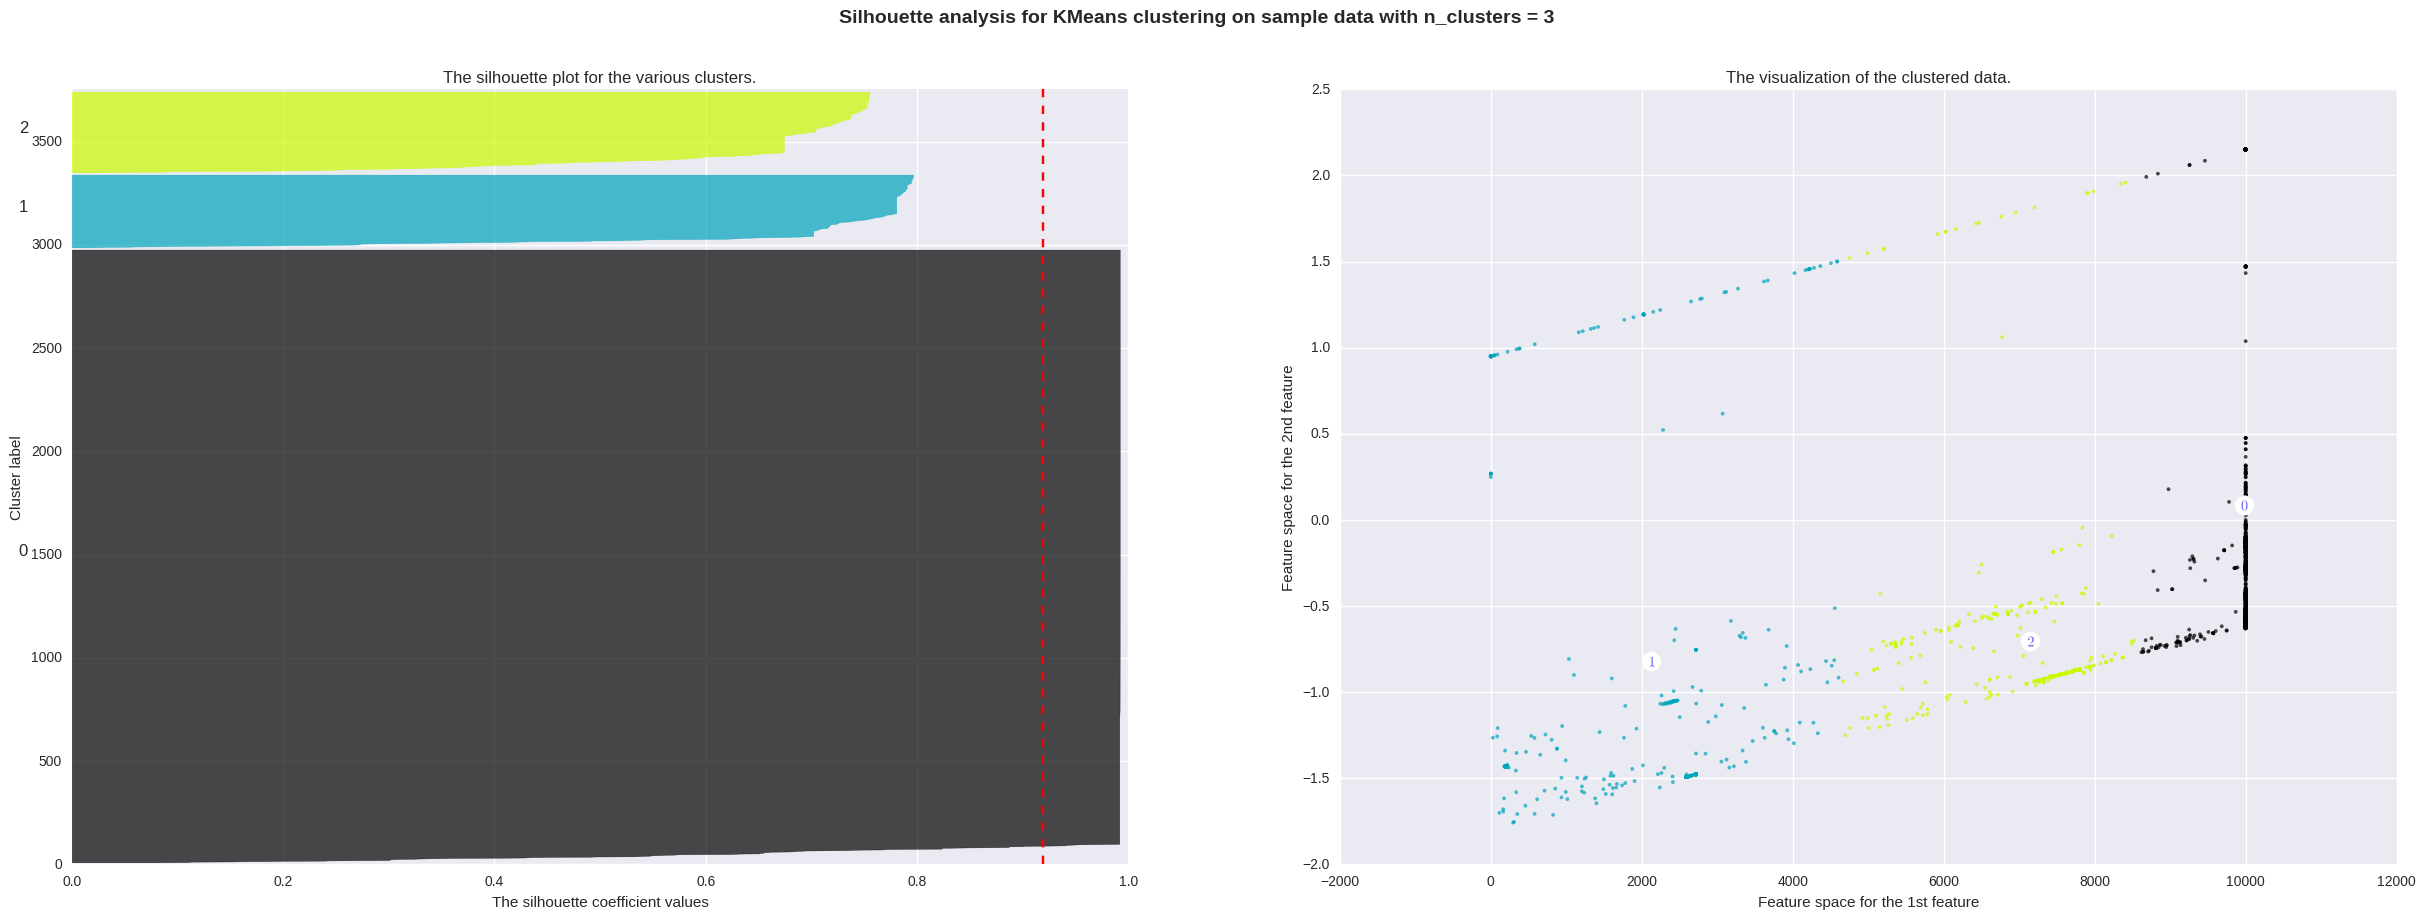

('For n_clusters =', 4, 'The average silhouette_score is :', 0.91455122086080121)


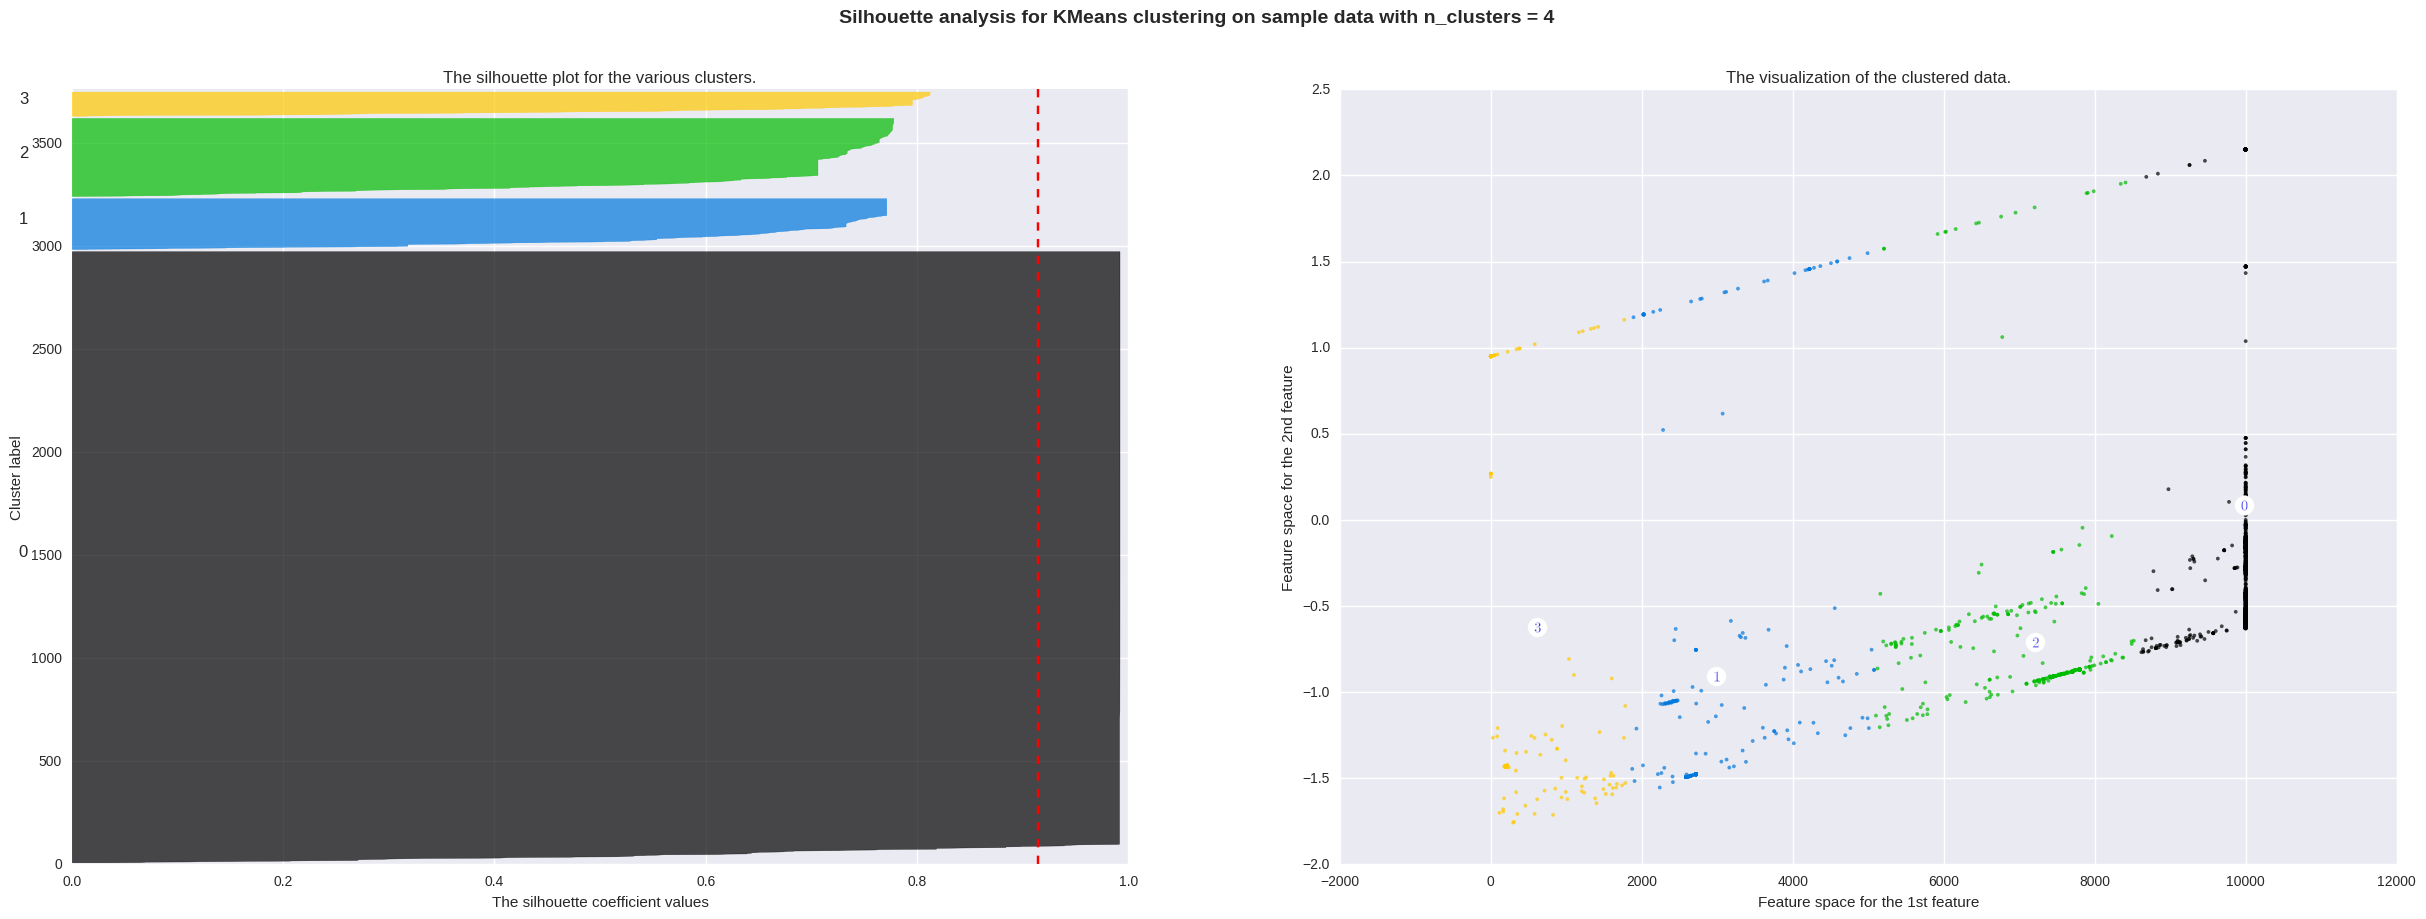

('For n_clusters =', 5, 'The average silhouette_score is :', 0.9245445021961809)


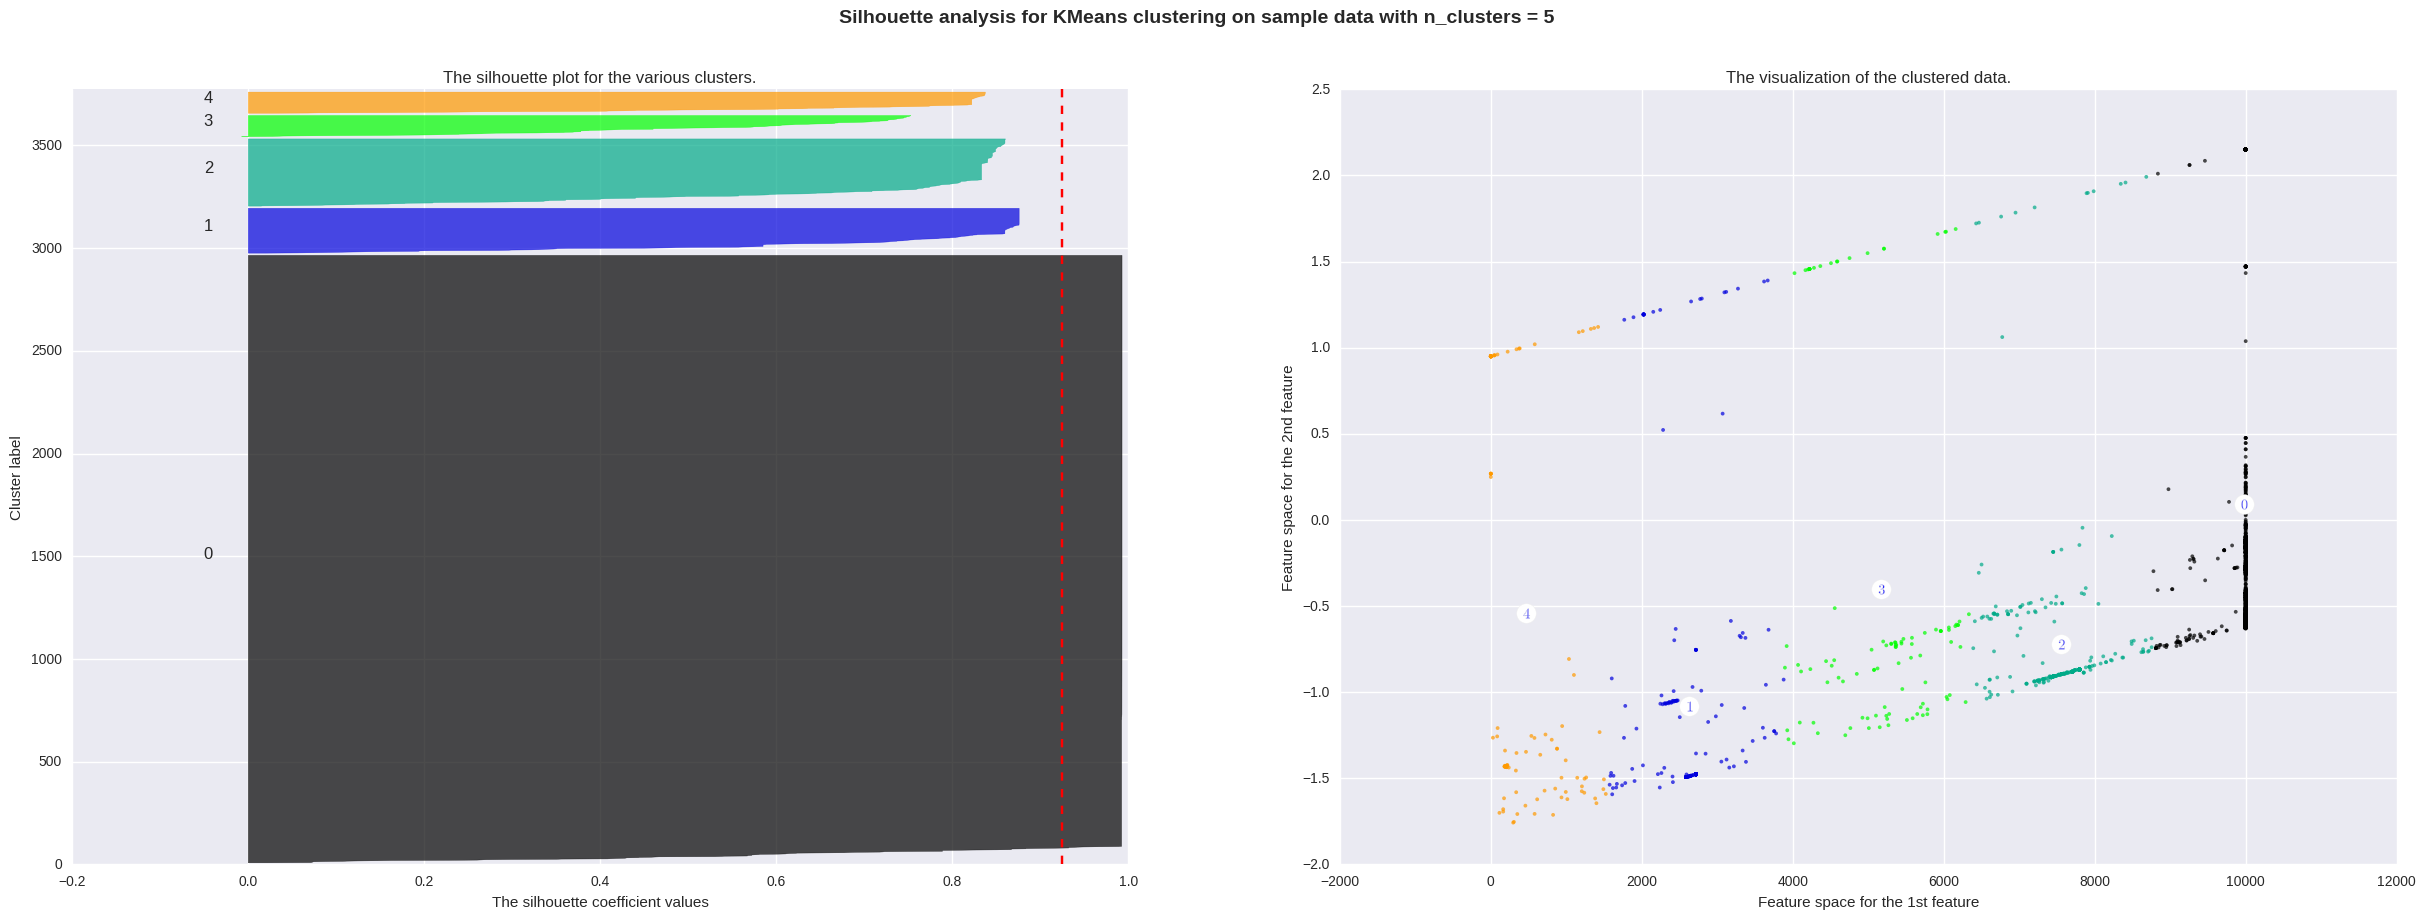

('For n_clusters =', 6, 'The average silhouette_score is :', 0.91736602913973675)


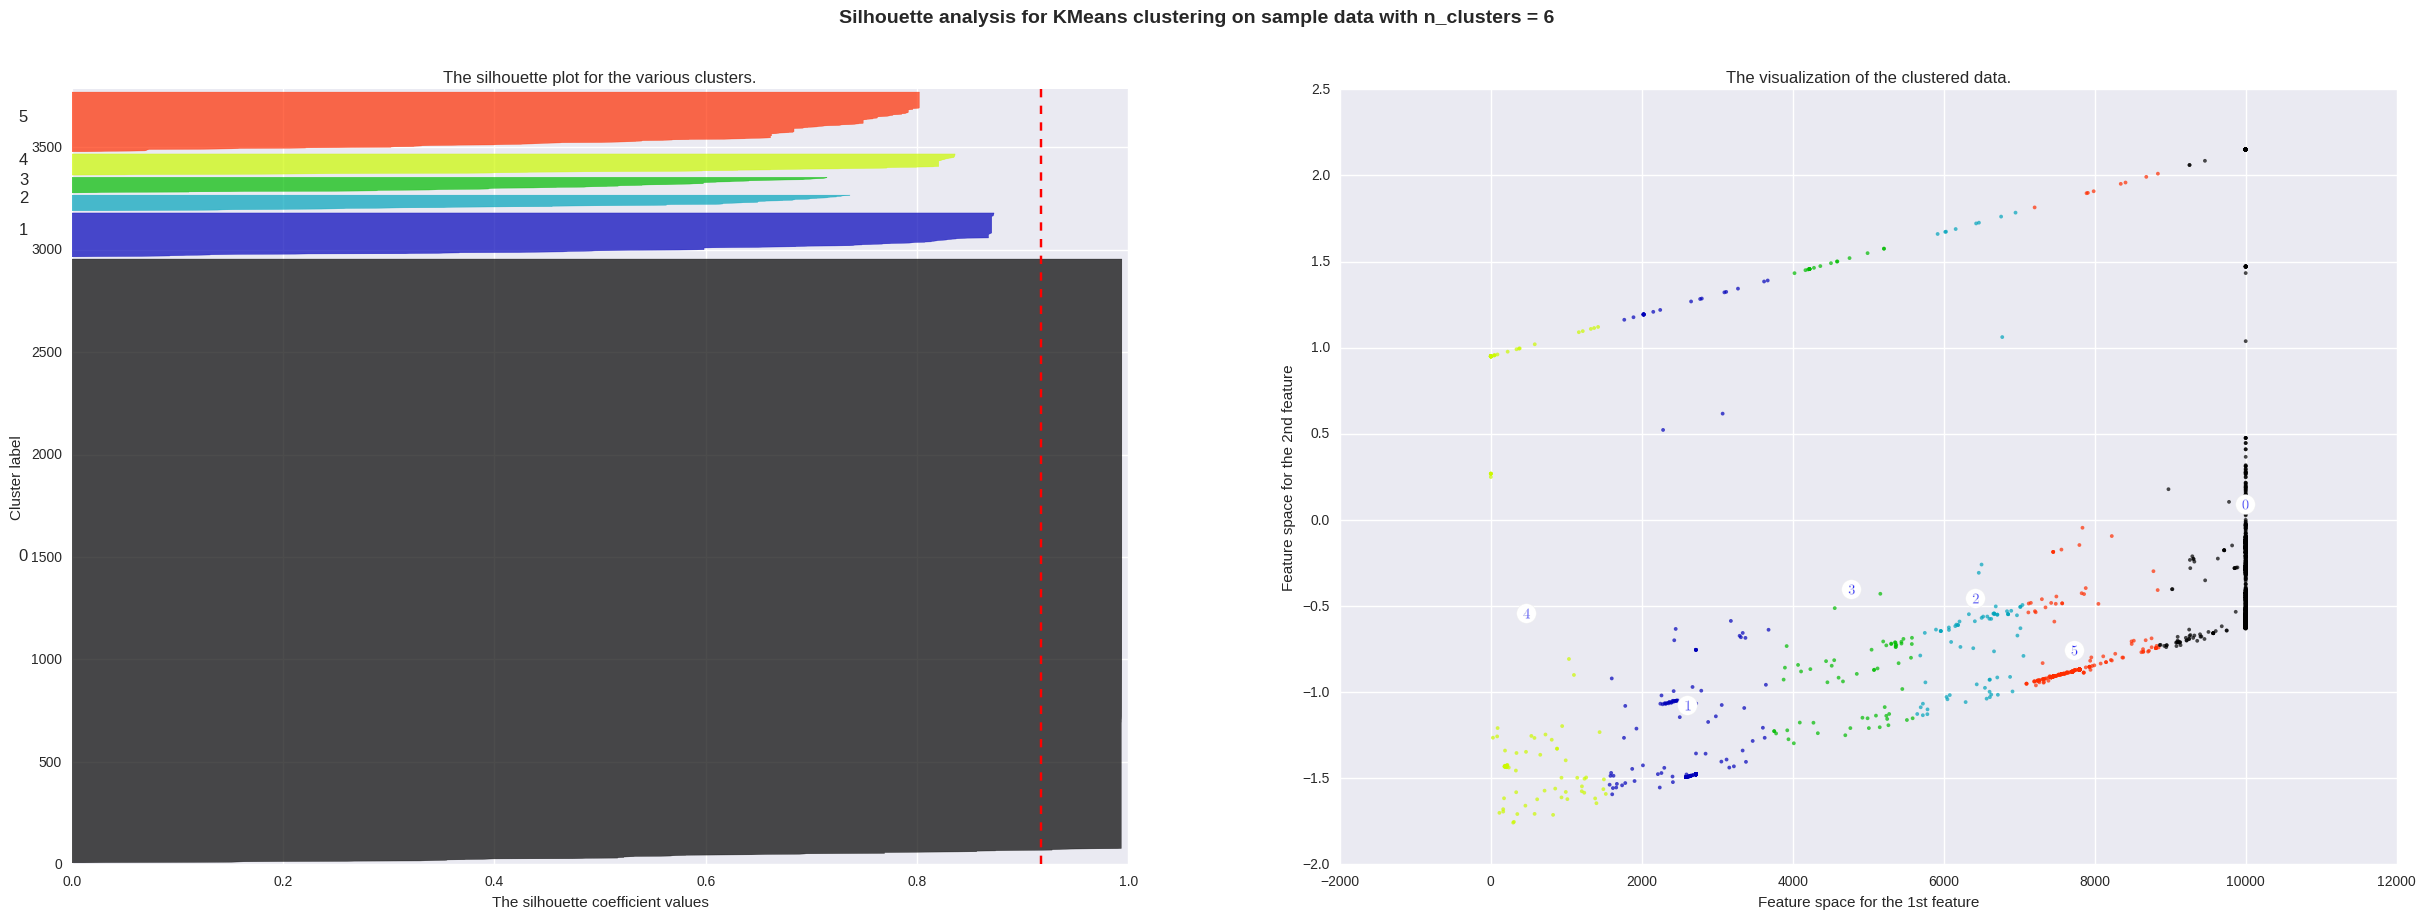

('For n_clusters =', 7, 'The average silhouette_score is :', 0.92478849426387133)


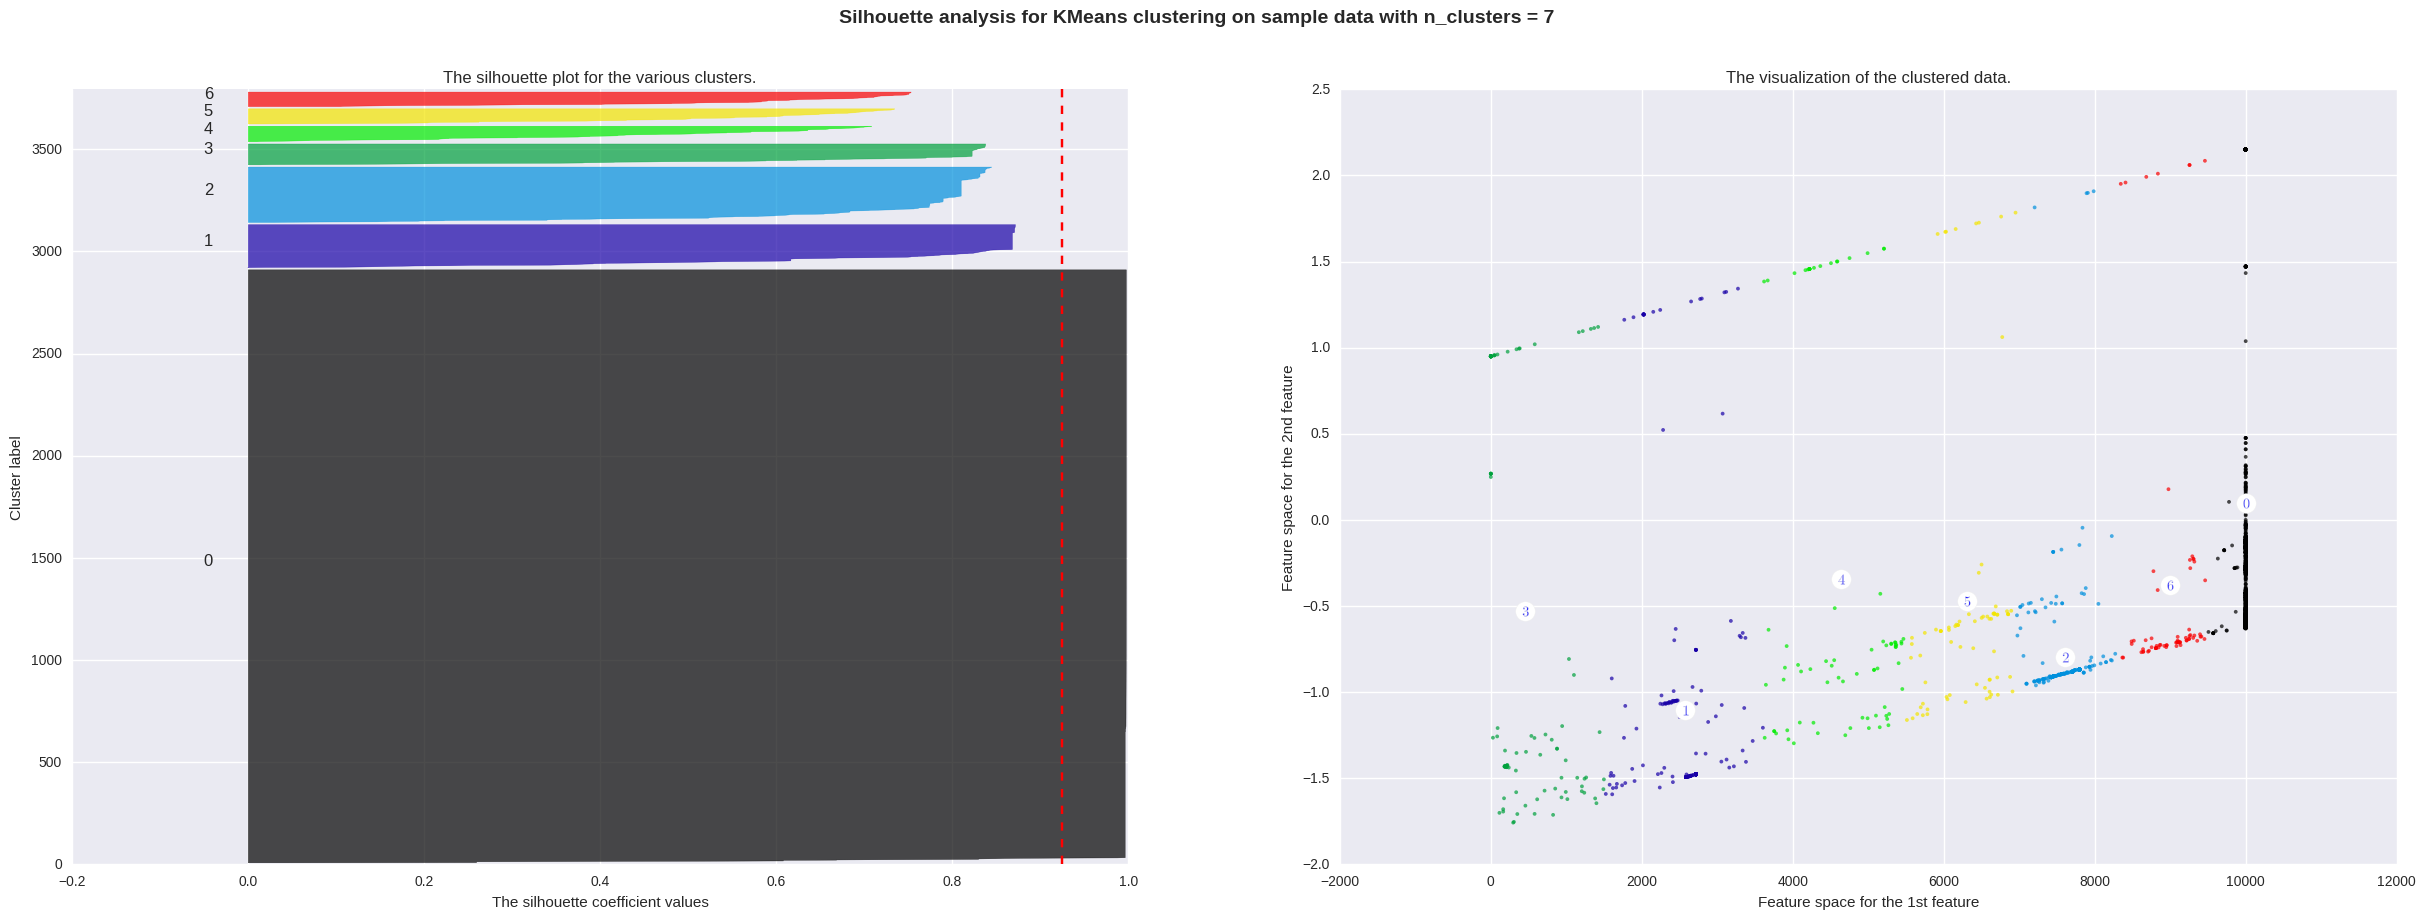

('For n_clusters =', 8, 'The average silhouette_score is :', 0.92293888280640213)


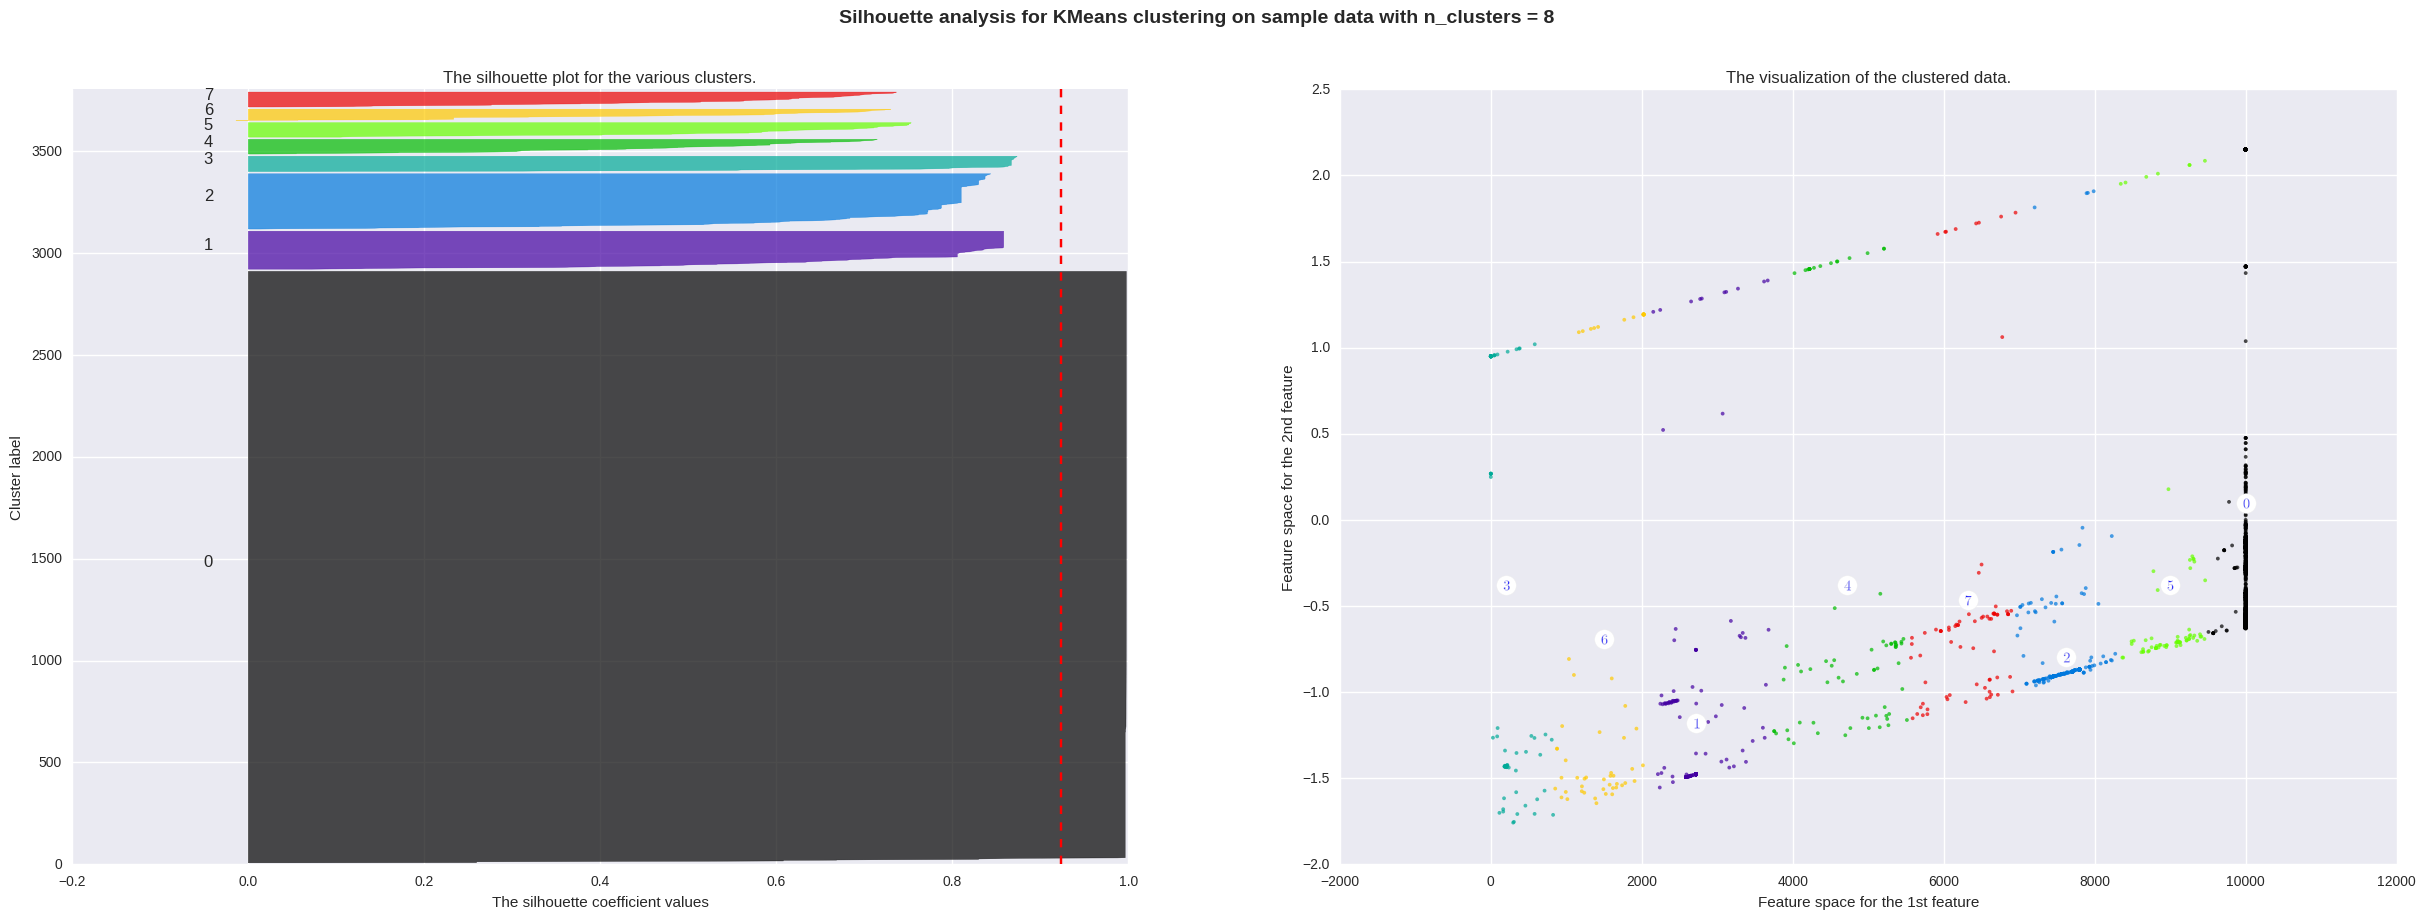

('For n_clusters =', 9, 'The average silhouette_score is :', 0.92399801813094873)


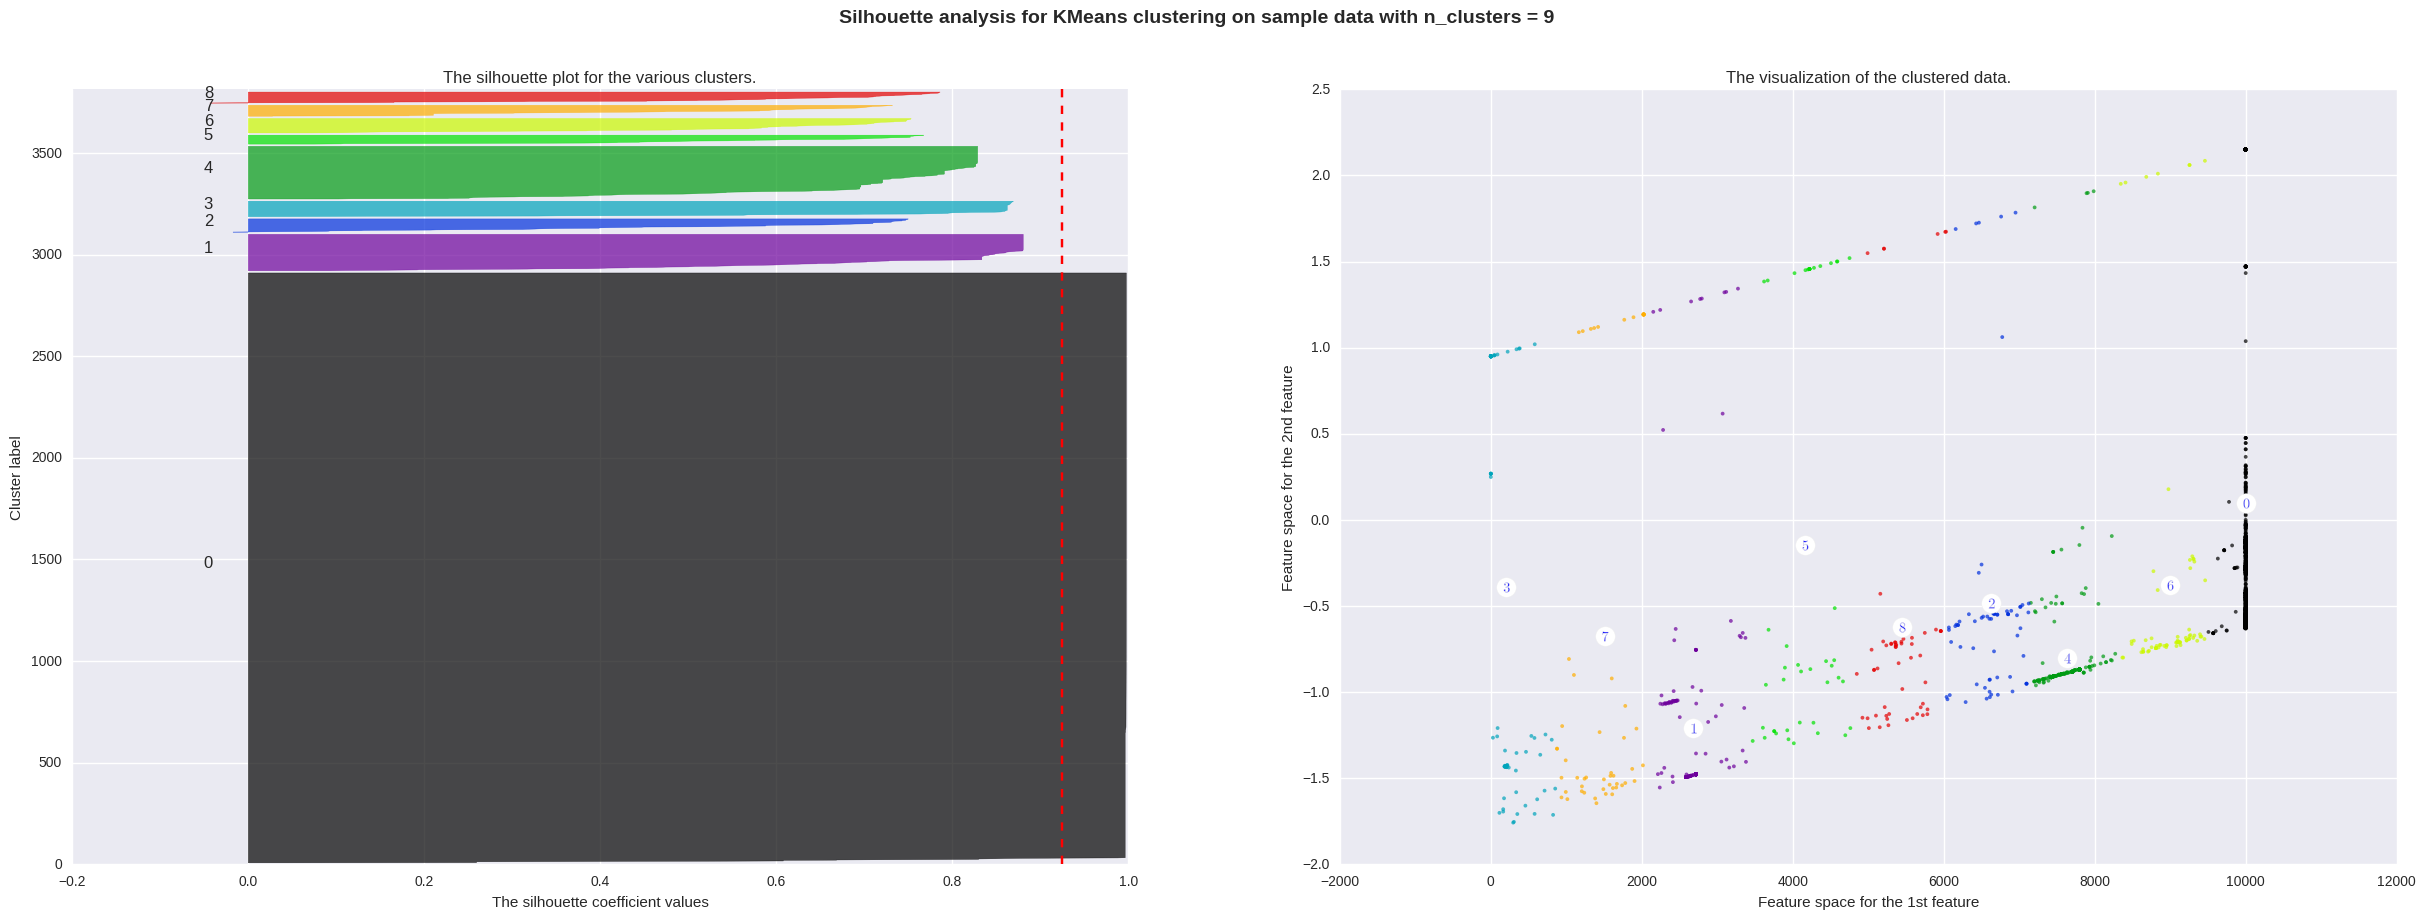

('For n_clusters =', 10, 'The average silhouette_score is :', 0.91923954650076445)


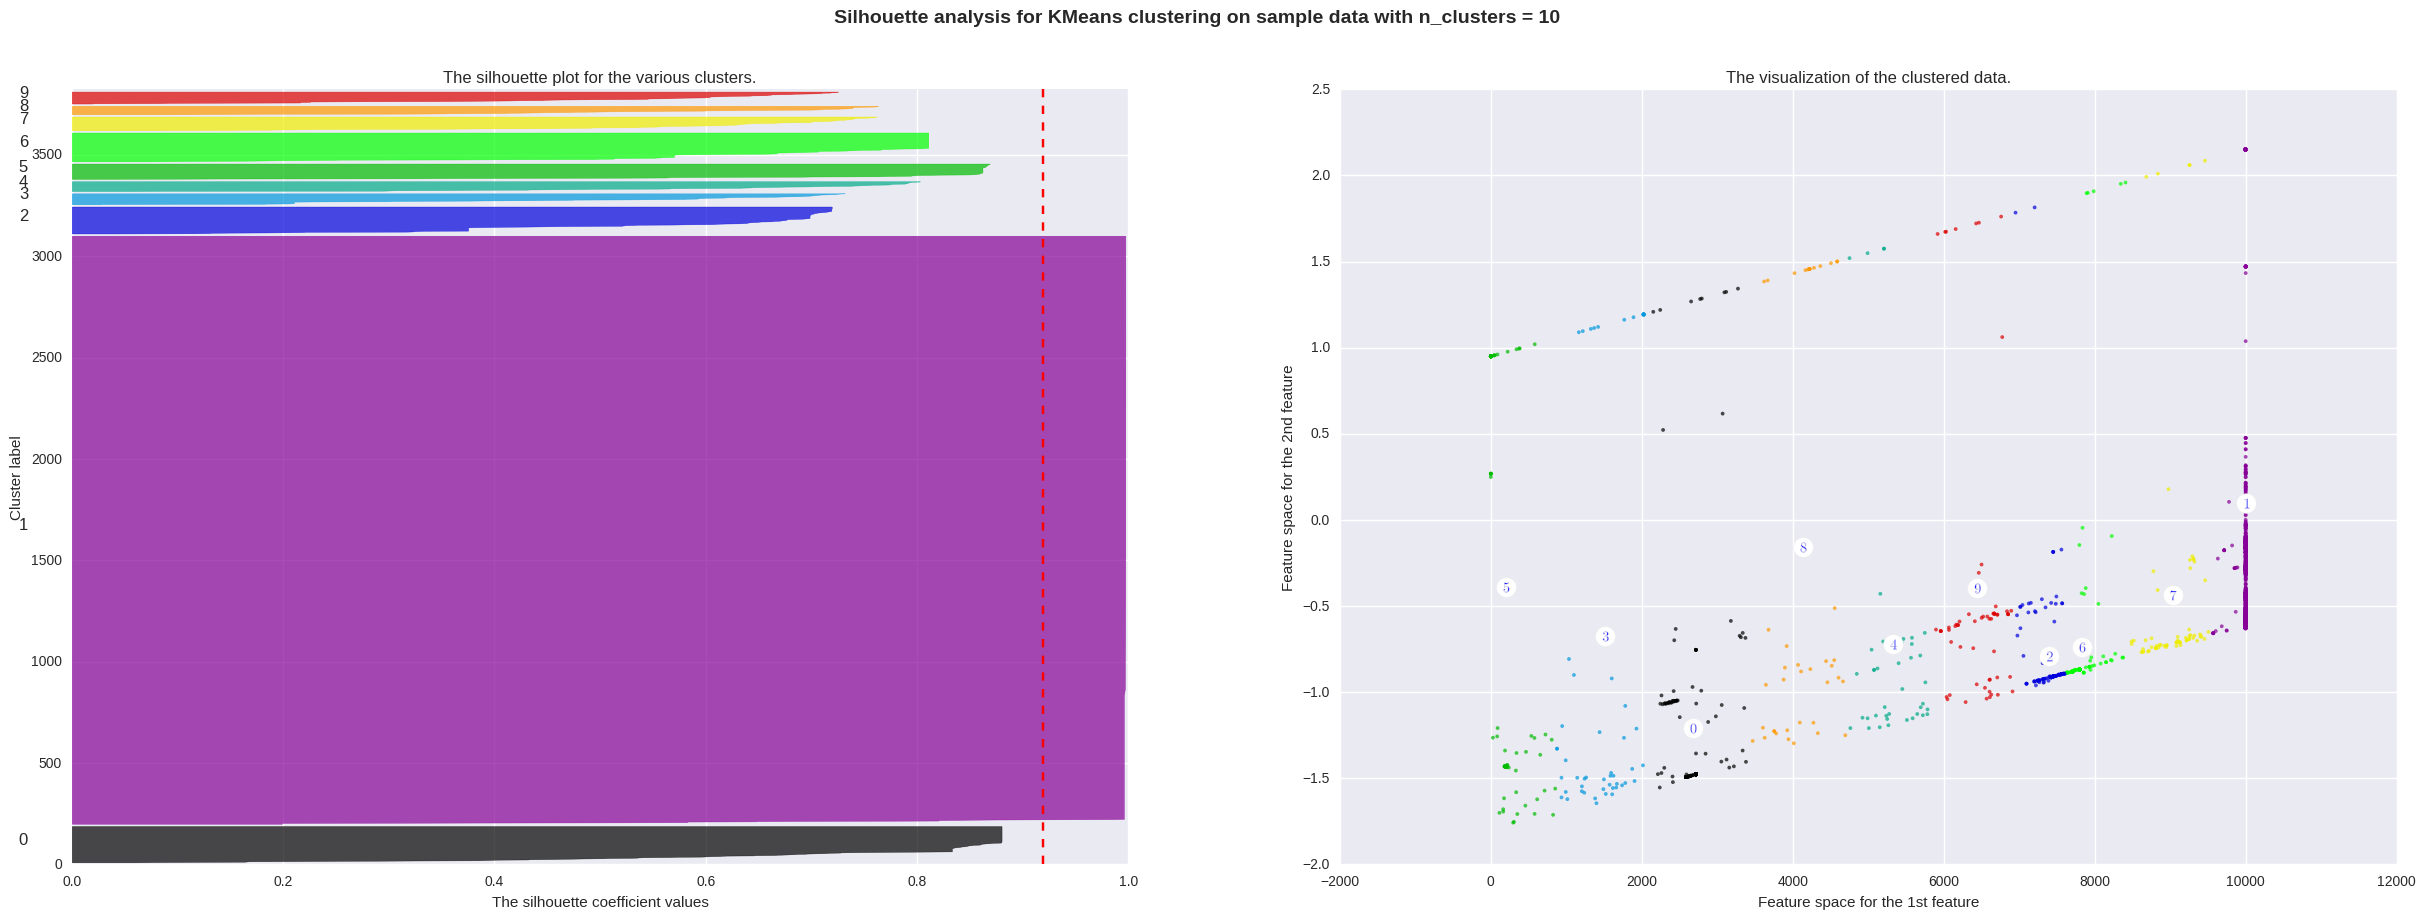

In [100]:
range_n_clusters = [3, 4, 5, 6,7,8,9,10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 10)
    
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(TSVD_3d_mopcode) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(TSVD_3d_mopcode)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(TSVD_3d_mopcode, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(TSVD_3d_mopcode, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(TSVD_3d_mopcode[:, 0], TSVD_3d_mopcode[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

      cluster_label                                             sha256
0                 0  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                 4  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 1  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 0  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 0  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 0  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                 0  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 0  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 1  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 0  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                0  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11                5  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                0  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

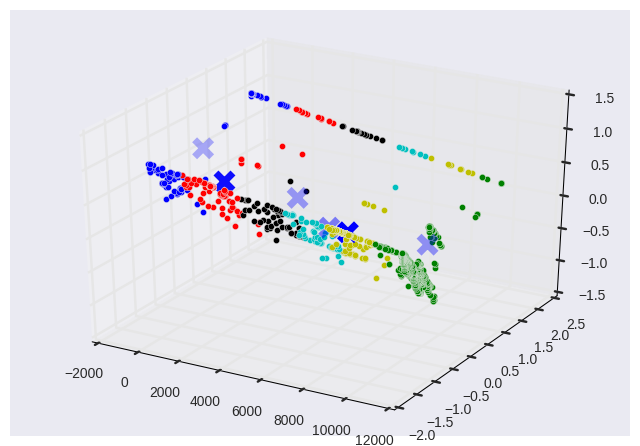

In [101]:
X = TSVD_3d_mopcode
cluster_num =6

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print "centroids : "
# print centroids
# print "labels : "
new_df_mopcode = pd.concat((pd.DataFrame(labels),malicious_dataframe['sha256']),axis=1).rename({}).rename(columns = {0:'cluster_label'})
print new_df_mopcode
color = ["g","r","c","y","b","k","m","w"]

# color = np.random.rand(cluster_num)

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')

for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
#     print "i : ",i
#     print "color[labels[i]] : ",color[labels[i]]
    ax.scatter(X[i][0], X[i][1], X[i][2], c=color[labels[i]])


for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2],marker = "x", s=150, linewidths = 5, zorder = 100)

plt.show()

      cluster_label                                             sha256
0                 0  a4ee7c0c5694a5f842ba967f4e1991de60be3ae6b1e32c...
1                 0  a201853a987fed8ed3b83eb3a56ce860d749497ee9d993...
2                 0  19c8825126dfc7d9fe0db48835ed4420315dec075726e4...
3                 0  0c0f9429b40b0c3f9579b4cfd1935edc1360111d71dc02...
4                 0  5a5fb59671373dccd4f3e0a81db04f81639b6013cda57f...
5                 0  f7b563e64c68c0ec5eed90a91b5b4bdbc482109c212288...
6                 0  1dde9371ba665fdae26cf93a3c566e91d5e4342a2a3fe1...
7                 0  bf16ad69d204d7357640410fd431911c124988bbf624e9...
8                 0  685db0fff323841b853316dfe49115cc84270e8bb20f55...
9                 4  c26b0b1d6bc9e9f700e90f0c55e4e462db054d63e68137...
10                6  f611b5f49f361c52936ea5641179ef73026863cab64dec...
11                0  9f7c5d509e5a6aef3b00091e33d3a4a583ba361d431d9e...
12                0  0b73a46c9242559cda4b6570409442c741a3aba7e00f6b...
13    

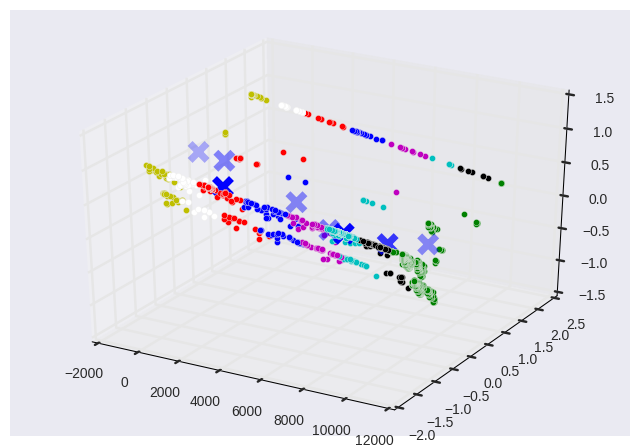

In [102]:
X = TSVD_3d_bopcode

cluster_num =8

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print "centroids : "
# print centroids
# print "labels : "
new_df_bopcode = pd.concat((pd.DataFrame(labels),benign_dataframe['sha256']),axis=1).rename({}).rename(columns = {0:'cluster_label'})
print new_df_bopcode
color = ["g","r","c","y","b","k","m","w"]

# color = np.random.rand(cluster_num)

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')

for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
#     print "i : ",i
#     print "color[labels[i]] : ",color[labels[i]]
    ax.scatter(X[i][0], X[i][1], X[i][2], c=color[labels[i]])


for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2],marker = "x", s=150, linewidths = 5, zorder = 100)

plt.show()

In [103]:
def plot_clusters(data, algorithm, args, kwds,sha_df):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    labels_df =  pd.DataFrame(labels)
    new_df = pd.concat((labels_df,sha_df),axis=1).rename({}).rename(columns = {0:'cluster_label'})
    print new_df
    clusters = labels.tolist()
    end_time = time.time()
    palette = sns.color_palette('muted', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.2, -0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [104]:

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

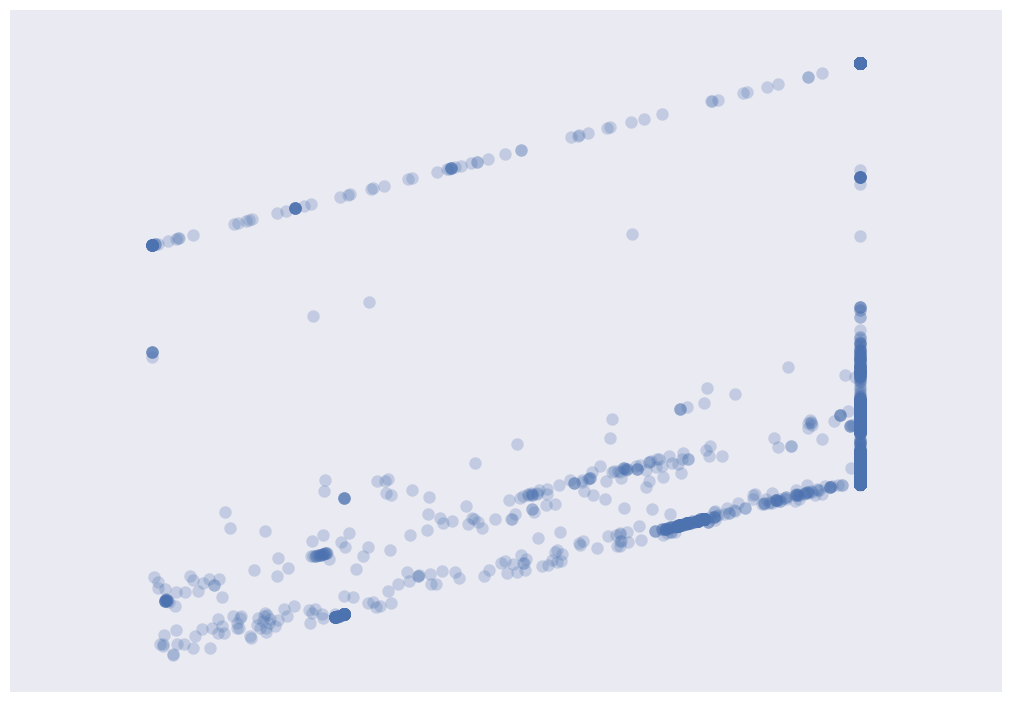

In [105]:
plt.scatter(TSVD_2d_mopcode[:,0], TSVD_2d_mopcode[:,1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

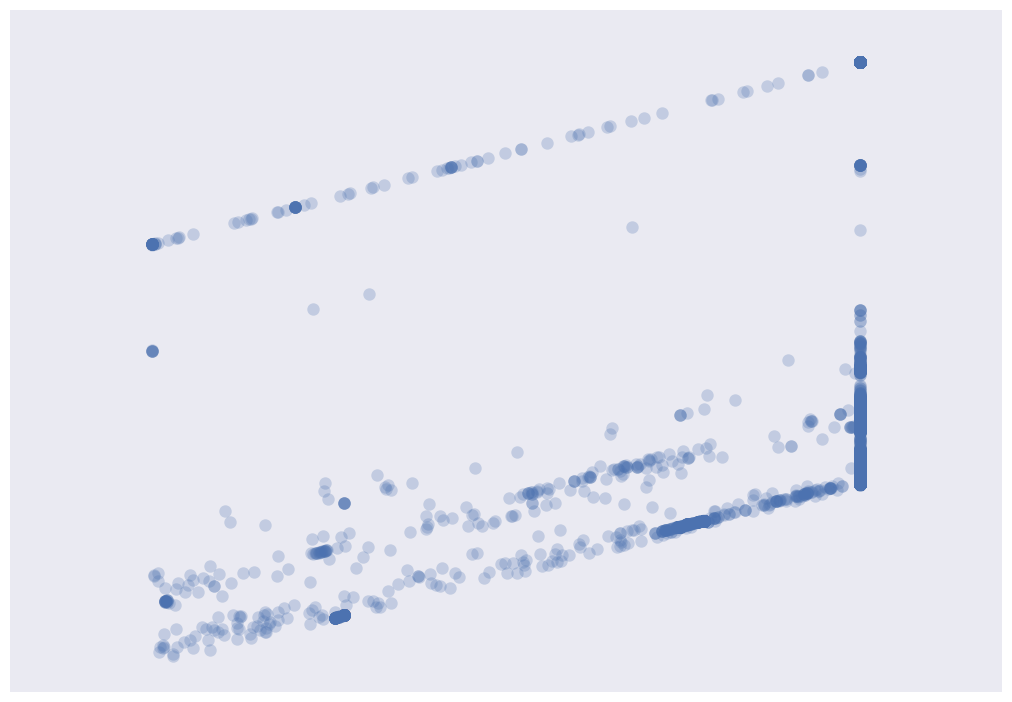

In [106]:
plt.scatter(TSVD_2d_bopcode[:,0], TSVD_2d_bopcode[:,1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

      cluster_label                                             sha256
0                 1  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                 2  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 4  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 1  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 1  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 1  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                 1  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 1  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 4  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 1  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                1  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11                3  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                1  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

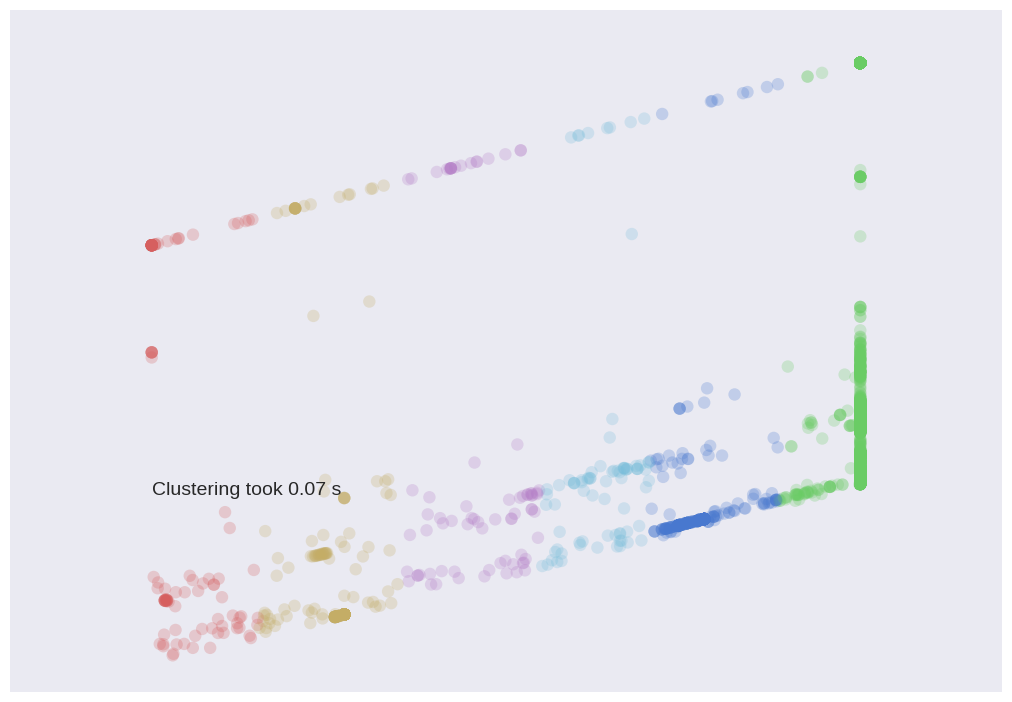

In [107]:
plot_clusters(TSVD_2d_mopcode, cluster.KMeans, (), {'n_clusters':6},malicious_dataframe['sha256'])


      cluster_label                                             sha256
0               161  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1               971  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 0  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3               161  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4               161  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5               161  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                 1  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 2  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 3  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9               161  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10              161  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11                4  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                5  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

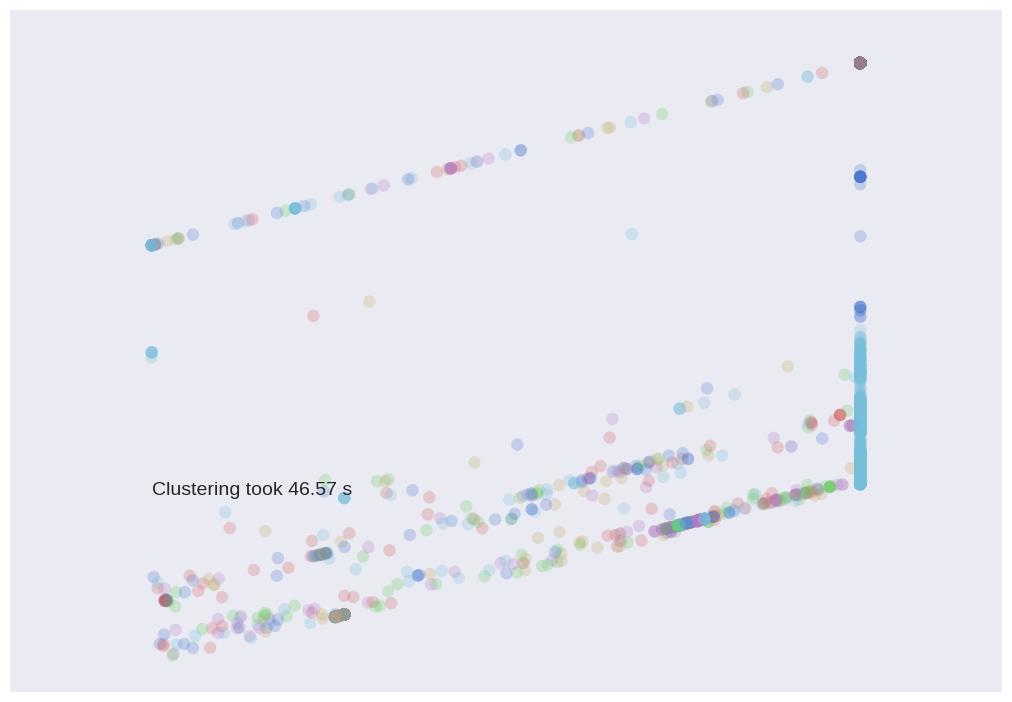

In [108]:
plot_clusters(TSVD_2d_mopcode, cluster.AffinityPropagation, (), {},malicious_dataframe['sha256'])

      cluster_label                                             sha256
0                 0  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                 3  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 2  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 0  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 0  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 0  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                 0  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 0  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 2  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 0  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                0  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11               -1  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                0  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

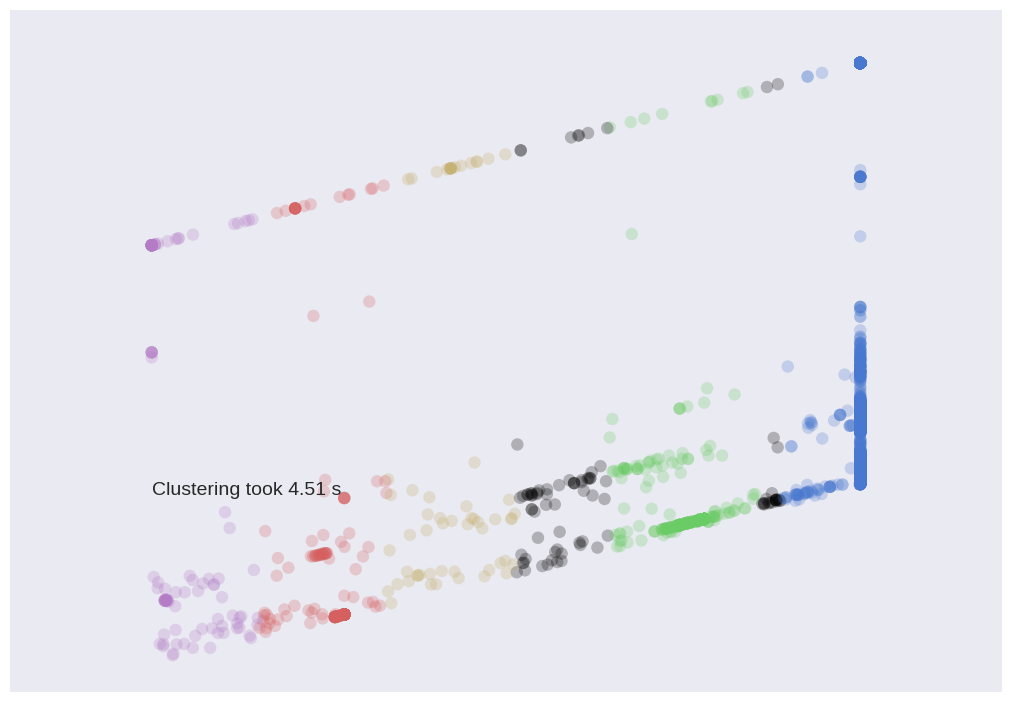

In [109]:
plot_clusters(TSVD_2d_mopcode, cluster.MeanShift, (), {'cluster_all':False},malicious_dataframe['sha256'])

In [110]:
# plot_clusters(TSVD_2d_mopcode, cluster.SpectralClustering, (), {'n_clusters':7},malicious_dataframe['sha256'])

      cluster_label                                             sha256
0                 0  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                 1  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 1  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 0  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 0  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 0  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                 0  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 0  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 1  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 0  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                0  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11                0  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                0  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

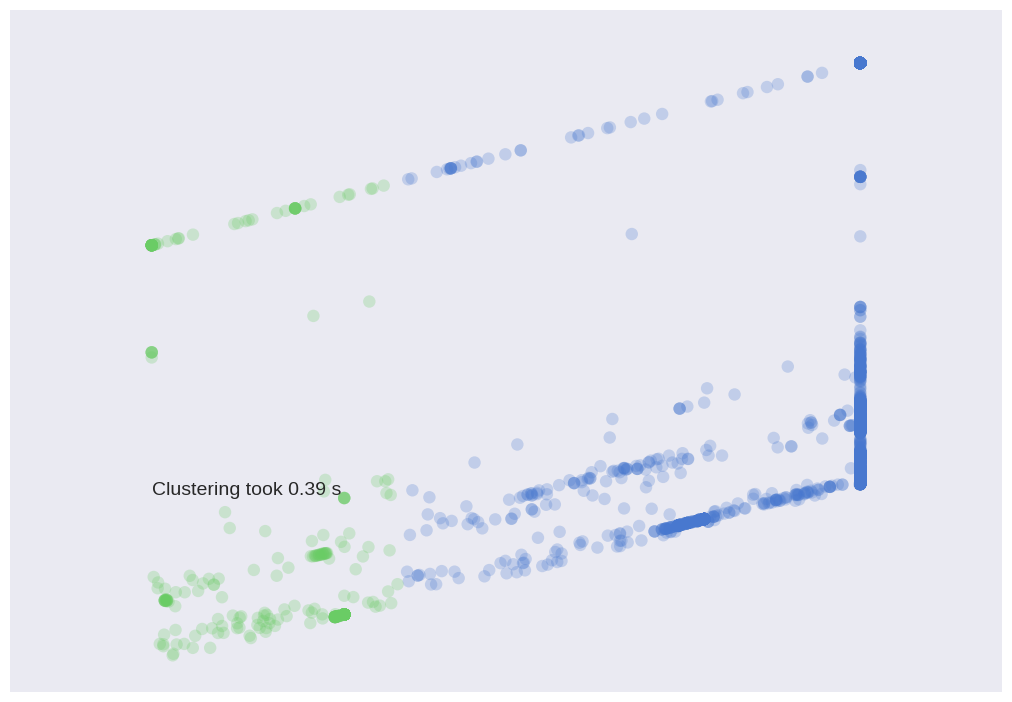

In [111]:
plot_clusters(TSVD_2d_mopcode, cluster.AgglomerativeClustering, (), { 'linkage':'ward'},malicious_dataframe['sha256'])

      cluster_label                                             sha256
0                 0  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                 1  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 2  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 0  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 0  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 0  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                -1  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 0  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 2  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 0  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                0  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11               -1  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                0  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

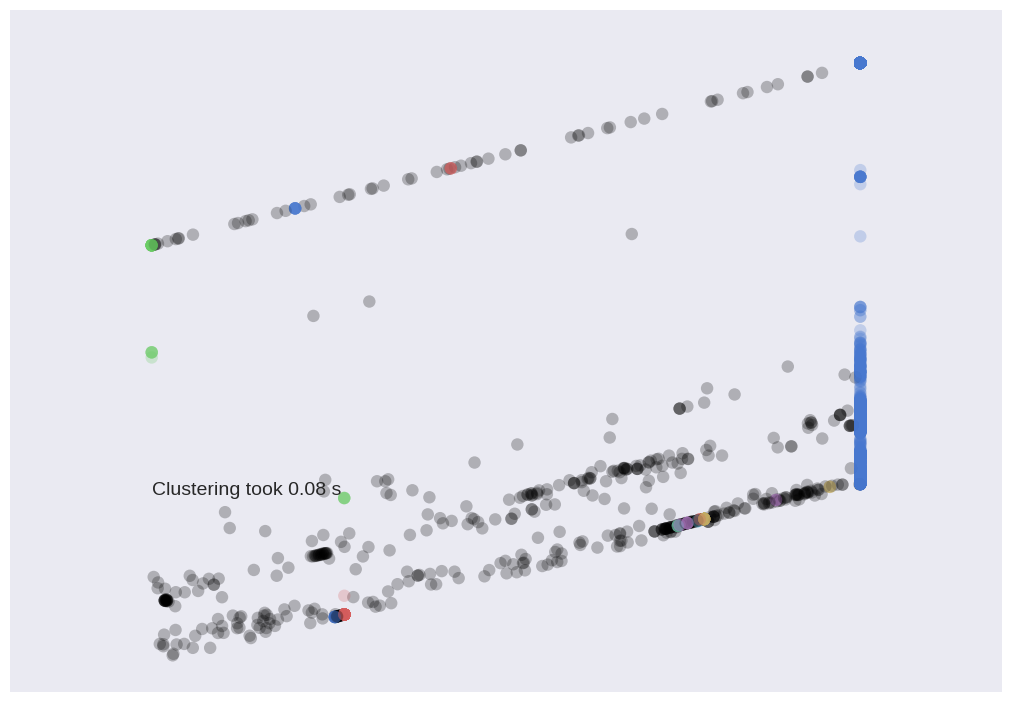

In [112]:
plot_clusters(TSVD_2d_mopcode, cluster.DBSCAN, (), {'eps':1},malicious_dataframe['sha256'])

      cluster_label                                             sha256
0                 2  07c5afe067488542e3abadfdb361fc11c170ddd1a63907...
1                -1  b5980892d1ba49a100aaee4ce23b09ba81b49b4681ebc5...
2                 0  6673f32b7c22e05c6754d1cb20d8978bbe1240e1dca4b1...
3                 2  22e9cb9ad2f3820c2fcc8c671ed5875ccaa30d7dc3f655...
4                 2  abb8f849ac81311b6667ae03fe1e0132a8a12abd3186bb...
5                 2  62902ad60577c26fdd7aa573160ad6eccefaea8e5f3c95...
6                -1  b04e3e82e4f0801a557986222c9cad0e67c1a63b19a0d5...
7                 3  209bd7ba16a8da1483d154c0071573f2a2b02f86c6e771...
8                 0  d64f1b797dcdecaabea2292e96a4793ac2b0eb286e0b05...
9                 2  d713424654c228643bab4f2575a48e26001dc4337f6cbd...
10                4  dff4d9c5845006c8df007516b994026c9630b549a86c17...
11               -1  d85d6cb69425fe52ebb229c7c7ea6839455057727394a3...
12                3  64686adf67ac6b76285e24b618af06109e2c70e704c4e1...
13    

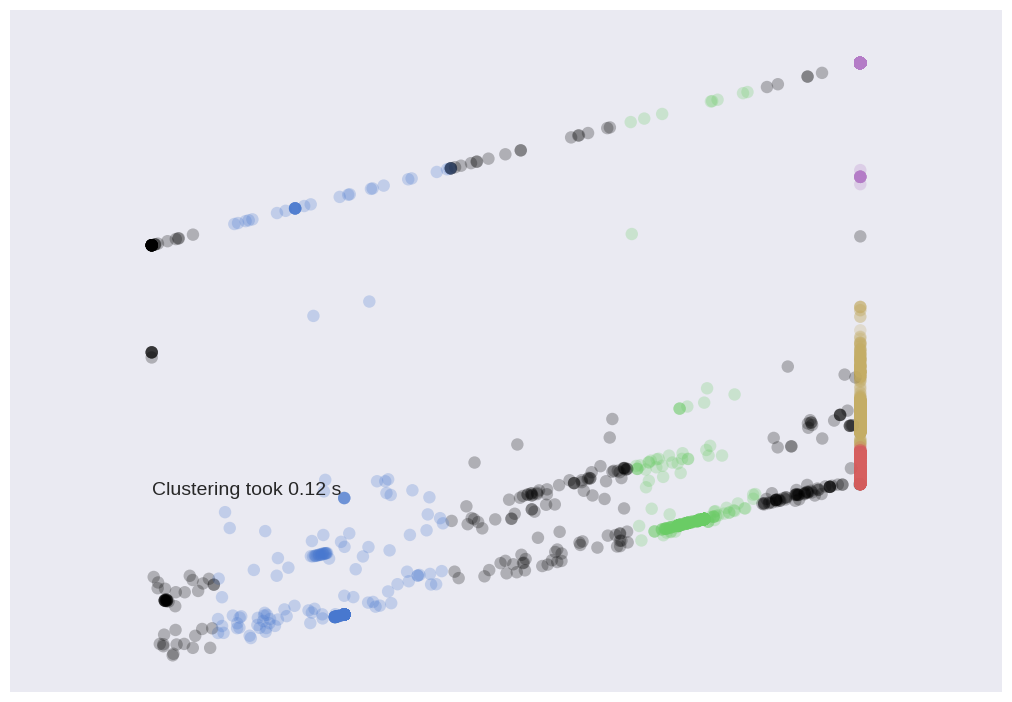

In [113]:
plot_clusters(TSVD_2d_mopcode, hdbscan.HDBSCAN, (), {'min_cluster_size':150},malicious_dataframe['sha256'])

### Clustering PEinfo

In [114]:
dist = 1 - cosine_similarity(total_textual_features_mal)

In [115]:
# from sklearn.manifold import MDS
# MDS()
# # convert two components as we're plotting points in a two-dimensional plane
# # "precomputed" because we provide a distance matrix
# # we will also specify `random_state` so the plot is reproducible.
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

# xs, ys = pos[:, 0], pos[:, 1]

### Dimensionality Reduction 

In [116]:
TSVD = TruncatedSVD(n_components=2).fit(total_textual_features_mal)
TSVD_3d_pe = TruncatedSVD(n_components=3).fit(total_textual_features_mal)
TSVD_nd_pe = TruncatedSVD(n_components=50).fit(total_textual_features_mal)

TSVD_2d = TSVD.transform(total_textual_features_mal)
TSVD_3d = TSVD_3d_pe.transform(total_textual_features_mal)
TSVD_pe_nd = TSVD_nd_pe.transform(total_textual_features_mal)


In [117]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
pd.set_option('display.max_colwidth', -1)

### Clustering PEinfo  & Visualization

('For n_clusters =', 3, 'The average silhouette_score is :', 0.72501480903533333)


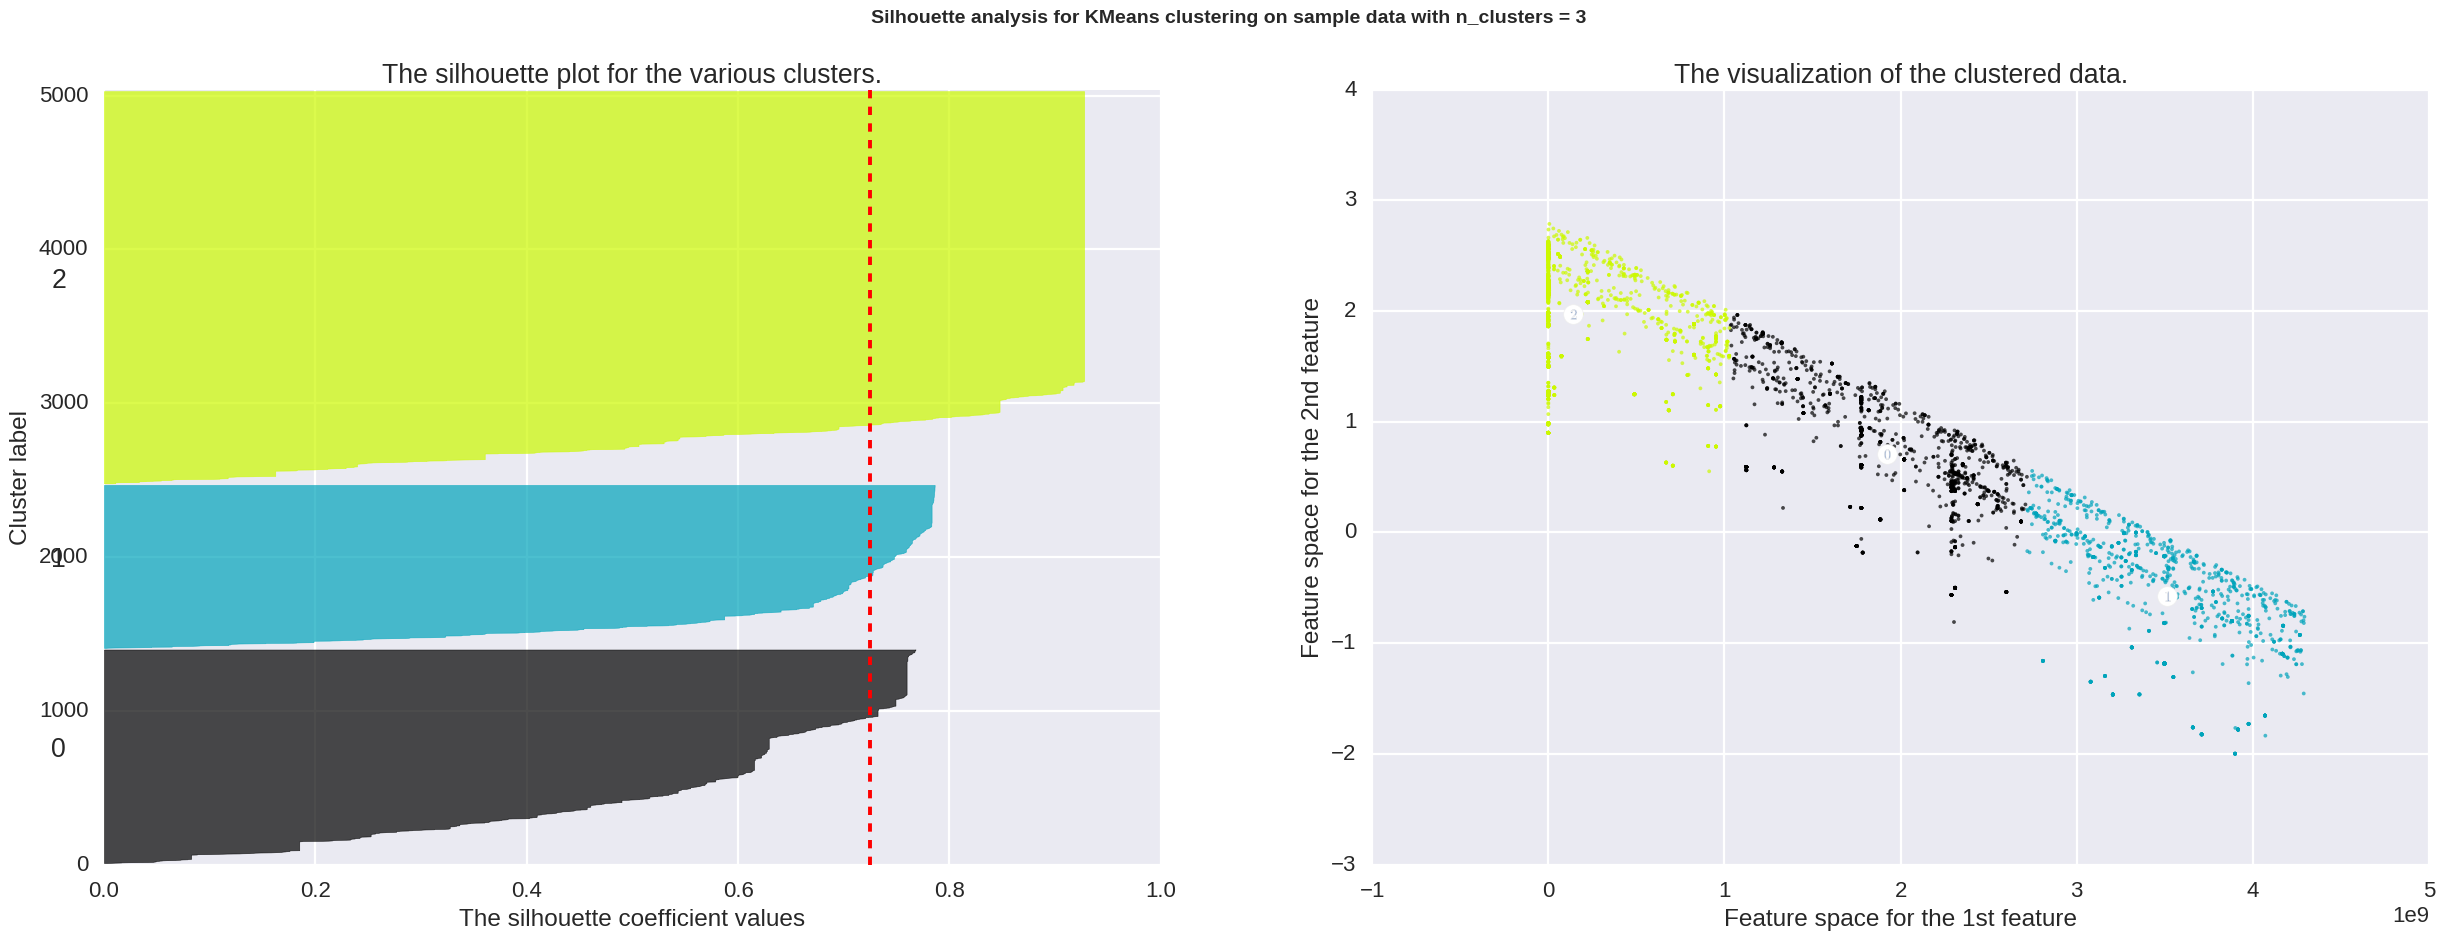

('For n_clusters =', 4, 'The average silhouette_score is :', 0.74368295954870878)


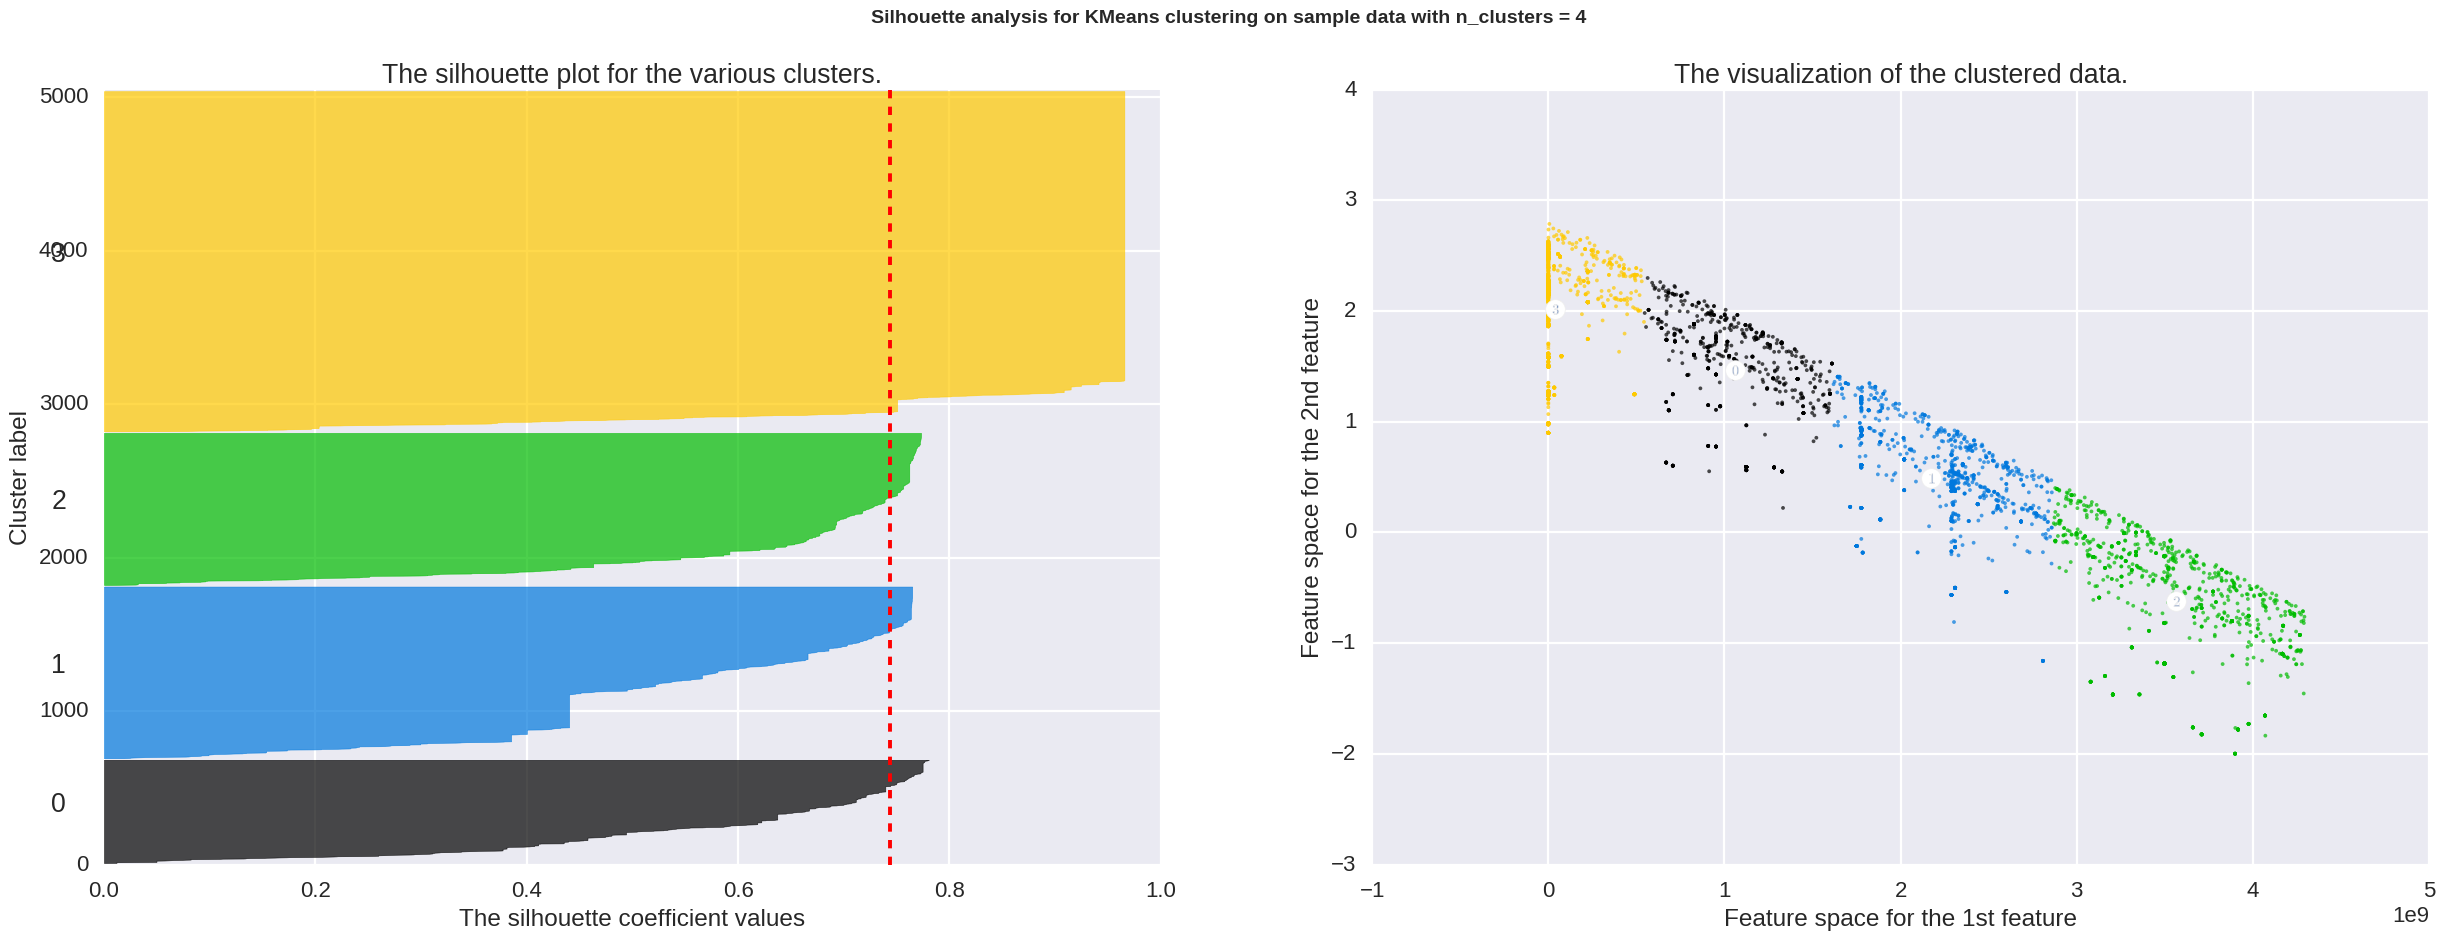

('For n_clusters =', 5, 'The average silhouette_score is :', 0.74713057502771463)


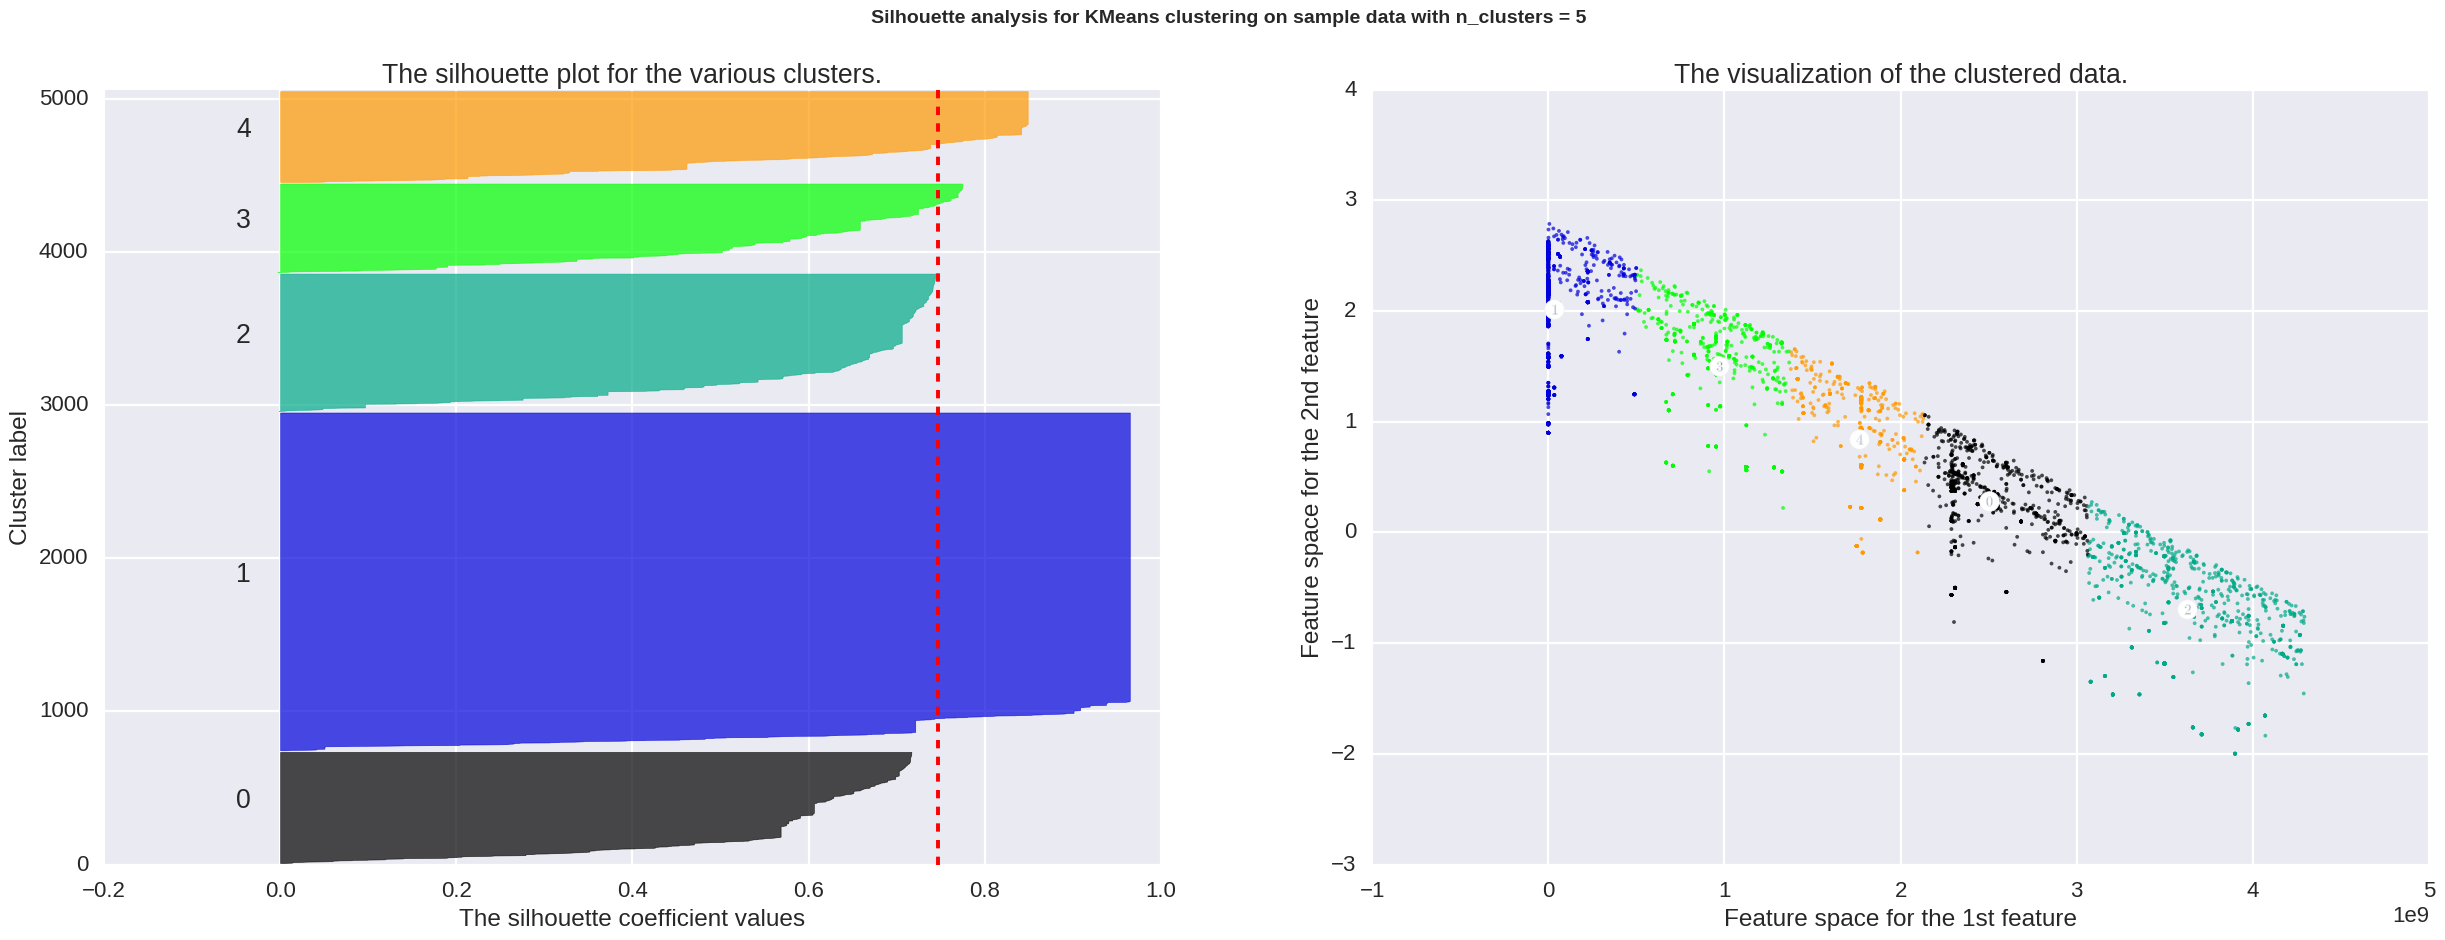

('For n_clusters =', 6, 'The average silhouette_score is :', 0.74872517685238693)


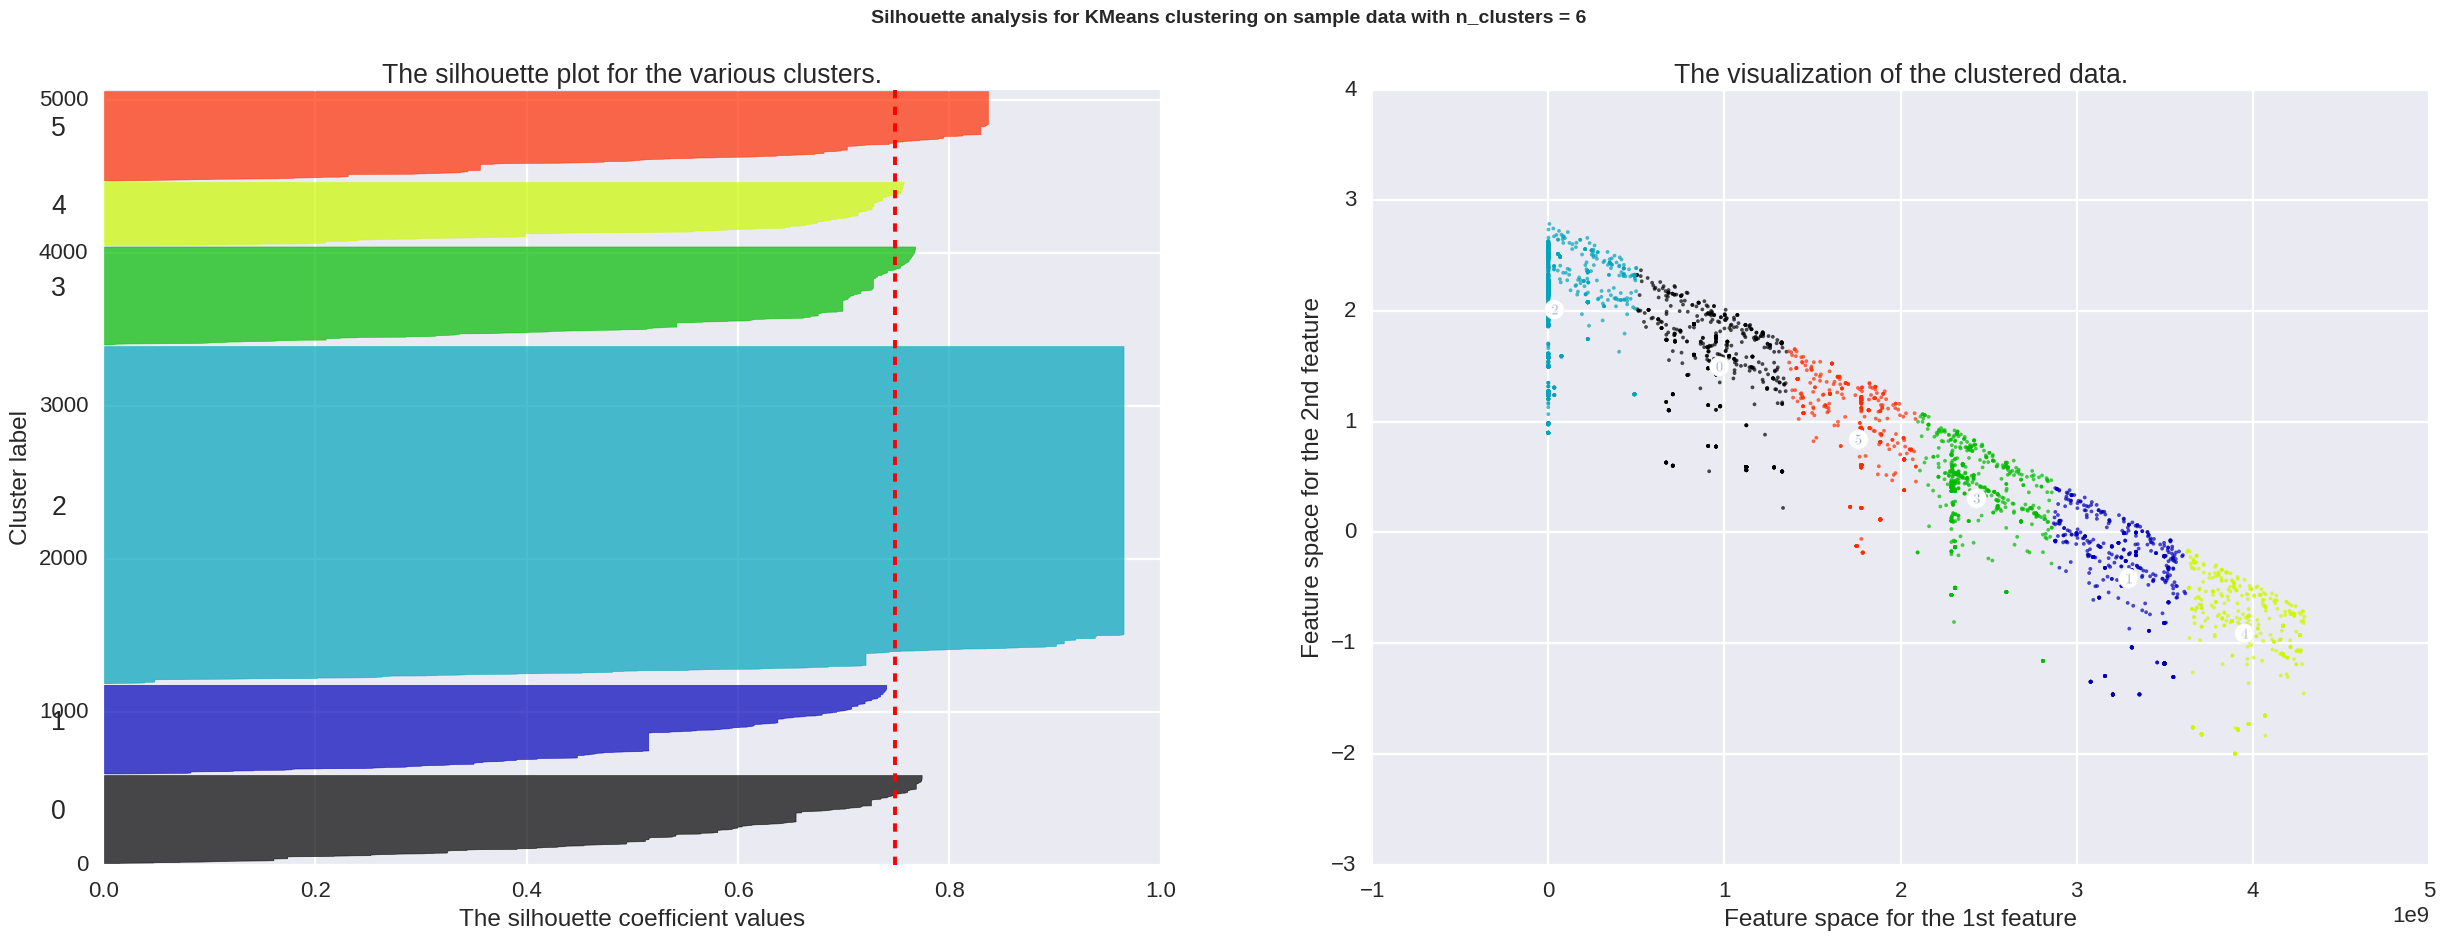

('For n_clusters =', 7, 'The average silhouette_score is :', 0.74277517943235272)


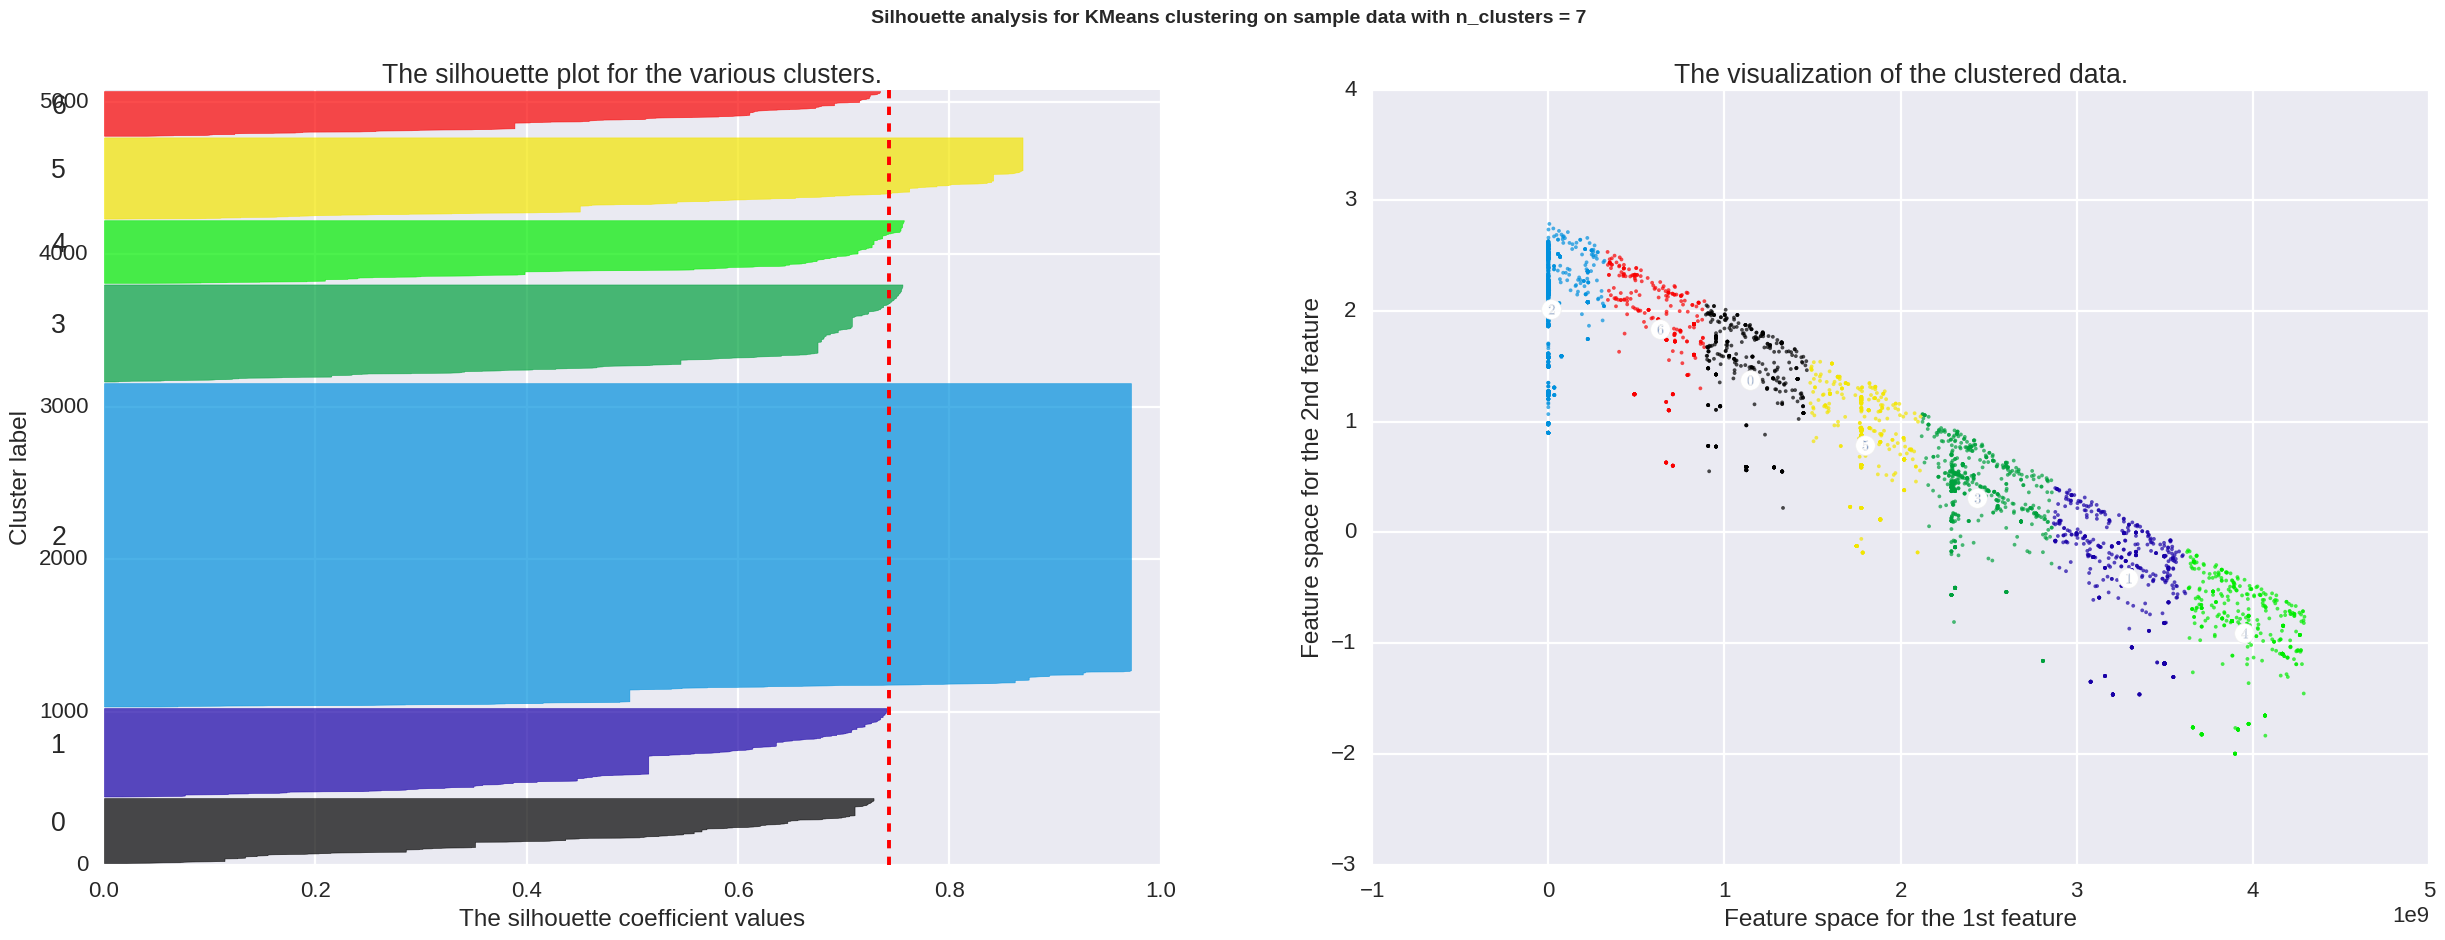

('For n_clusters =', 8, 'The average silhouette_score is :', 0.74875533783438131)


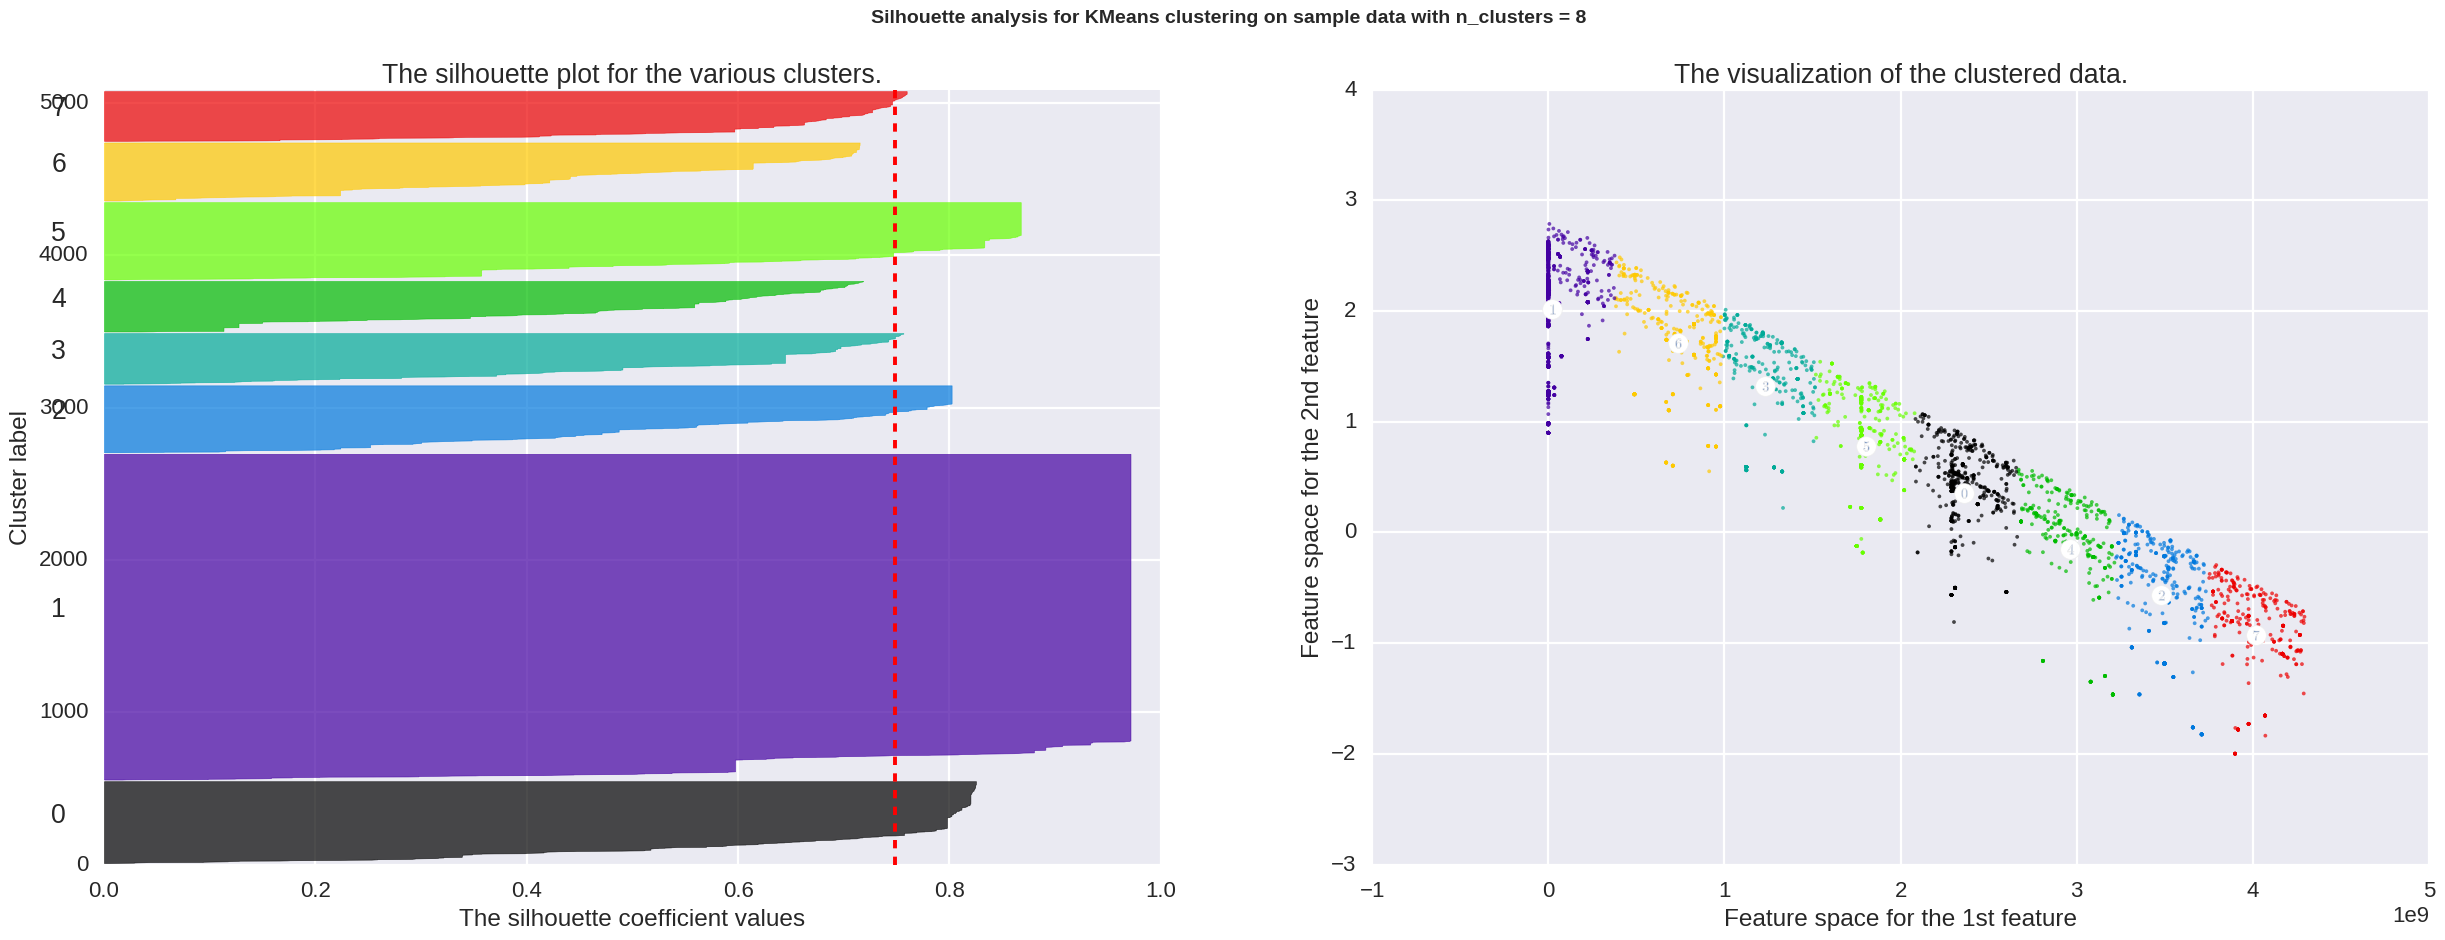

('For n_clusters =', 9, 'The average silhouette_score is :', 0.75608076385439615)


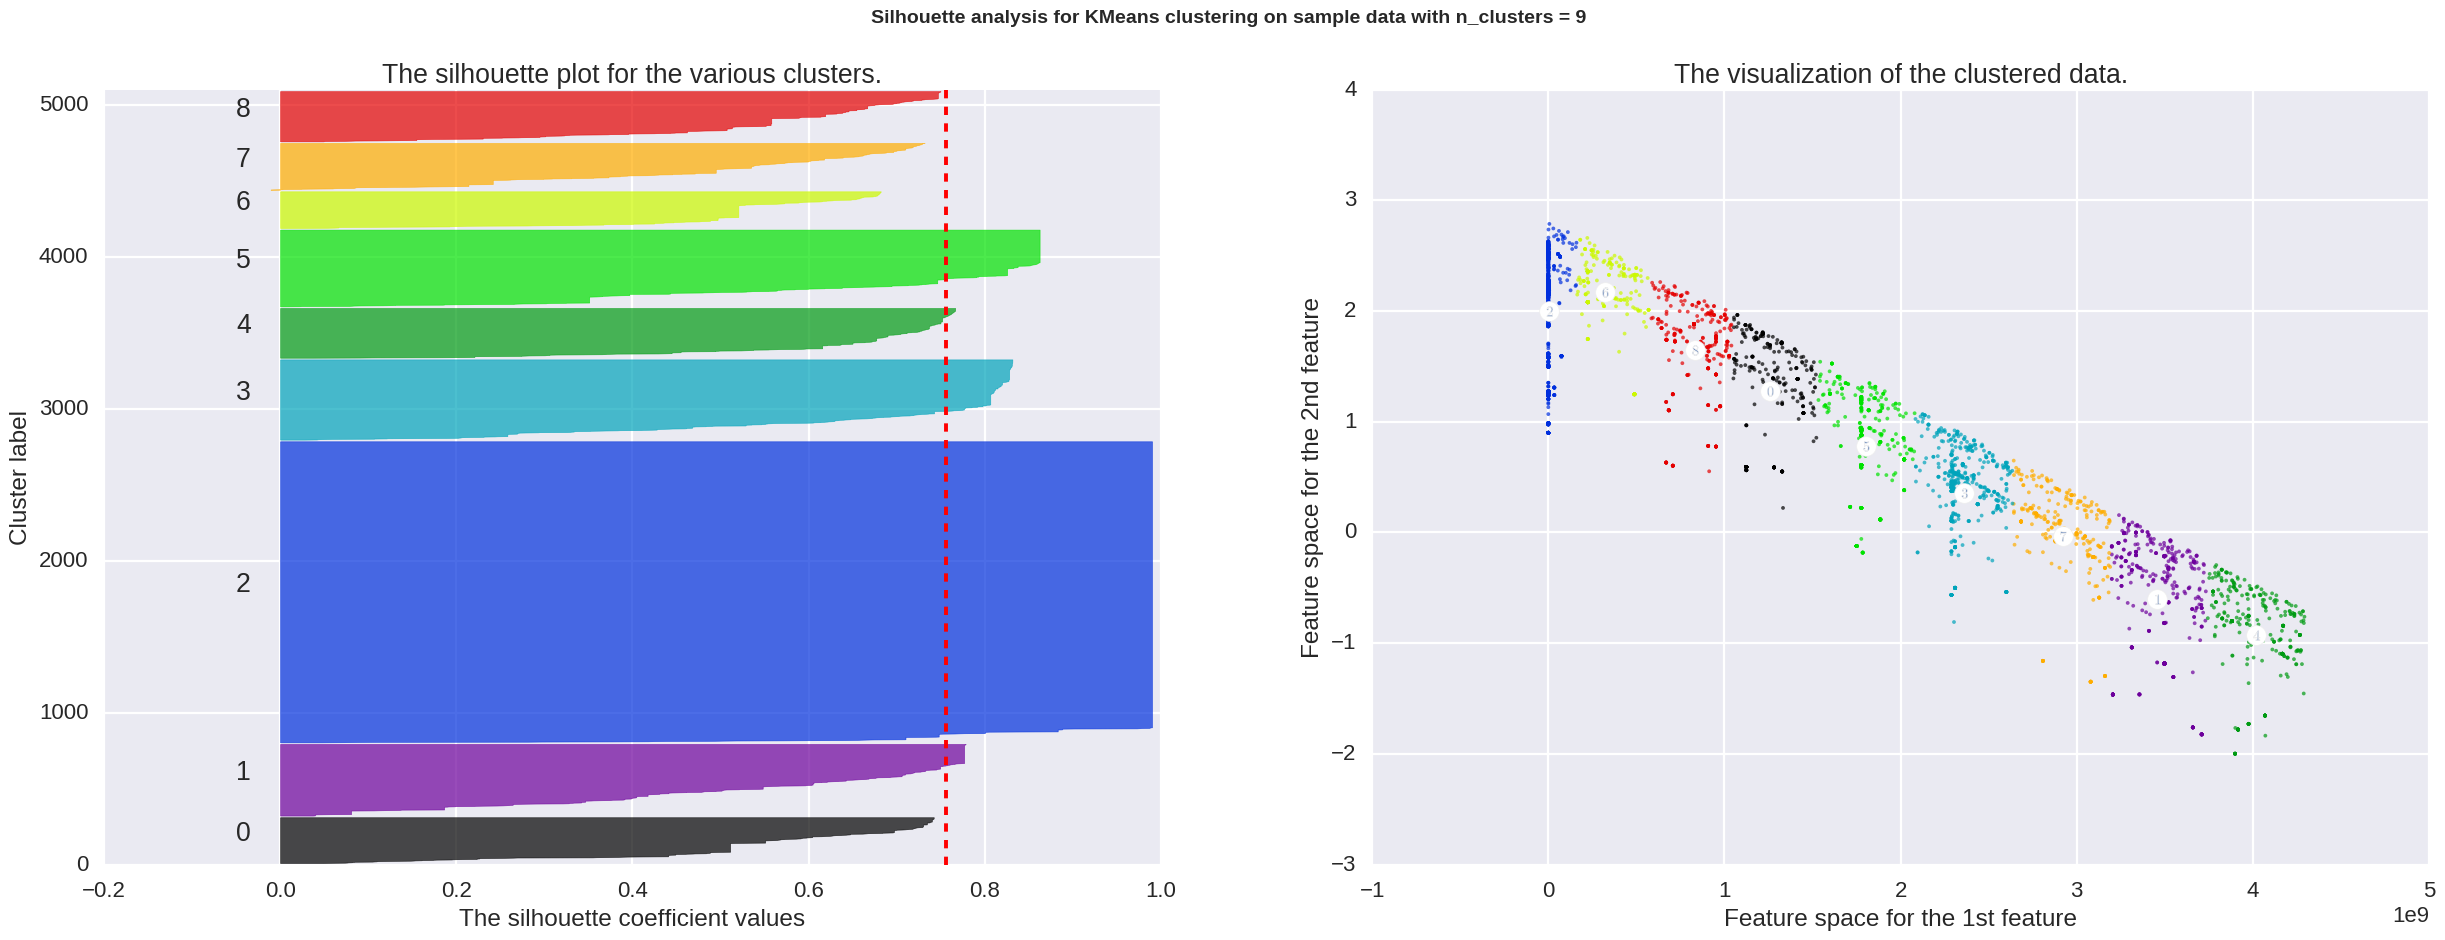

('For n_clusters =', 10, 'The average silhouette_score is :', 0.75877242449353455)


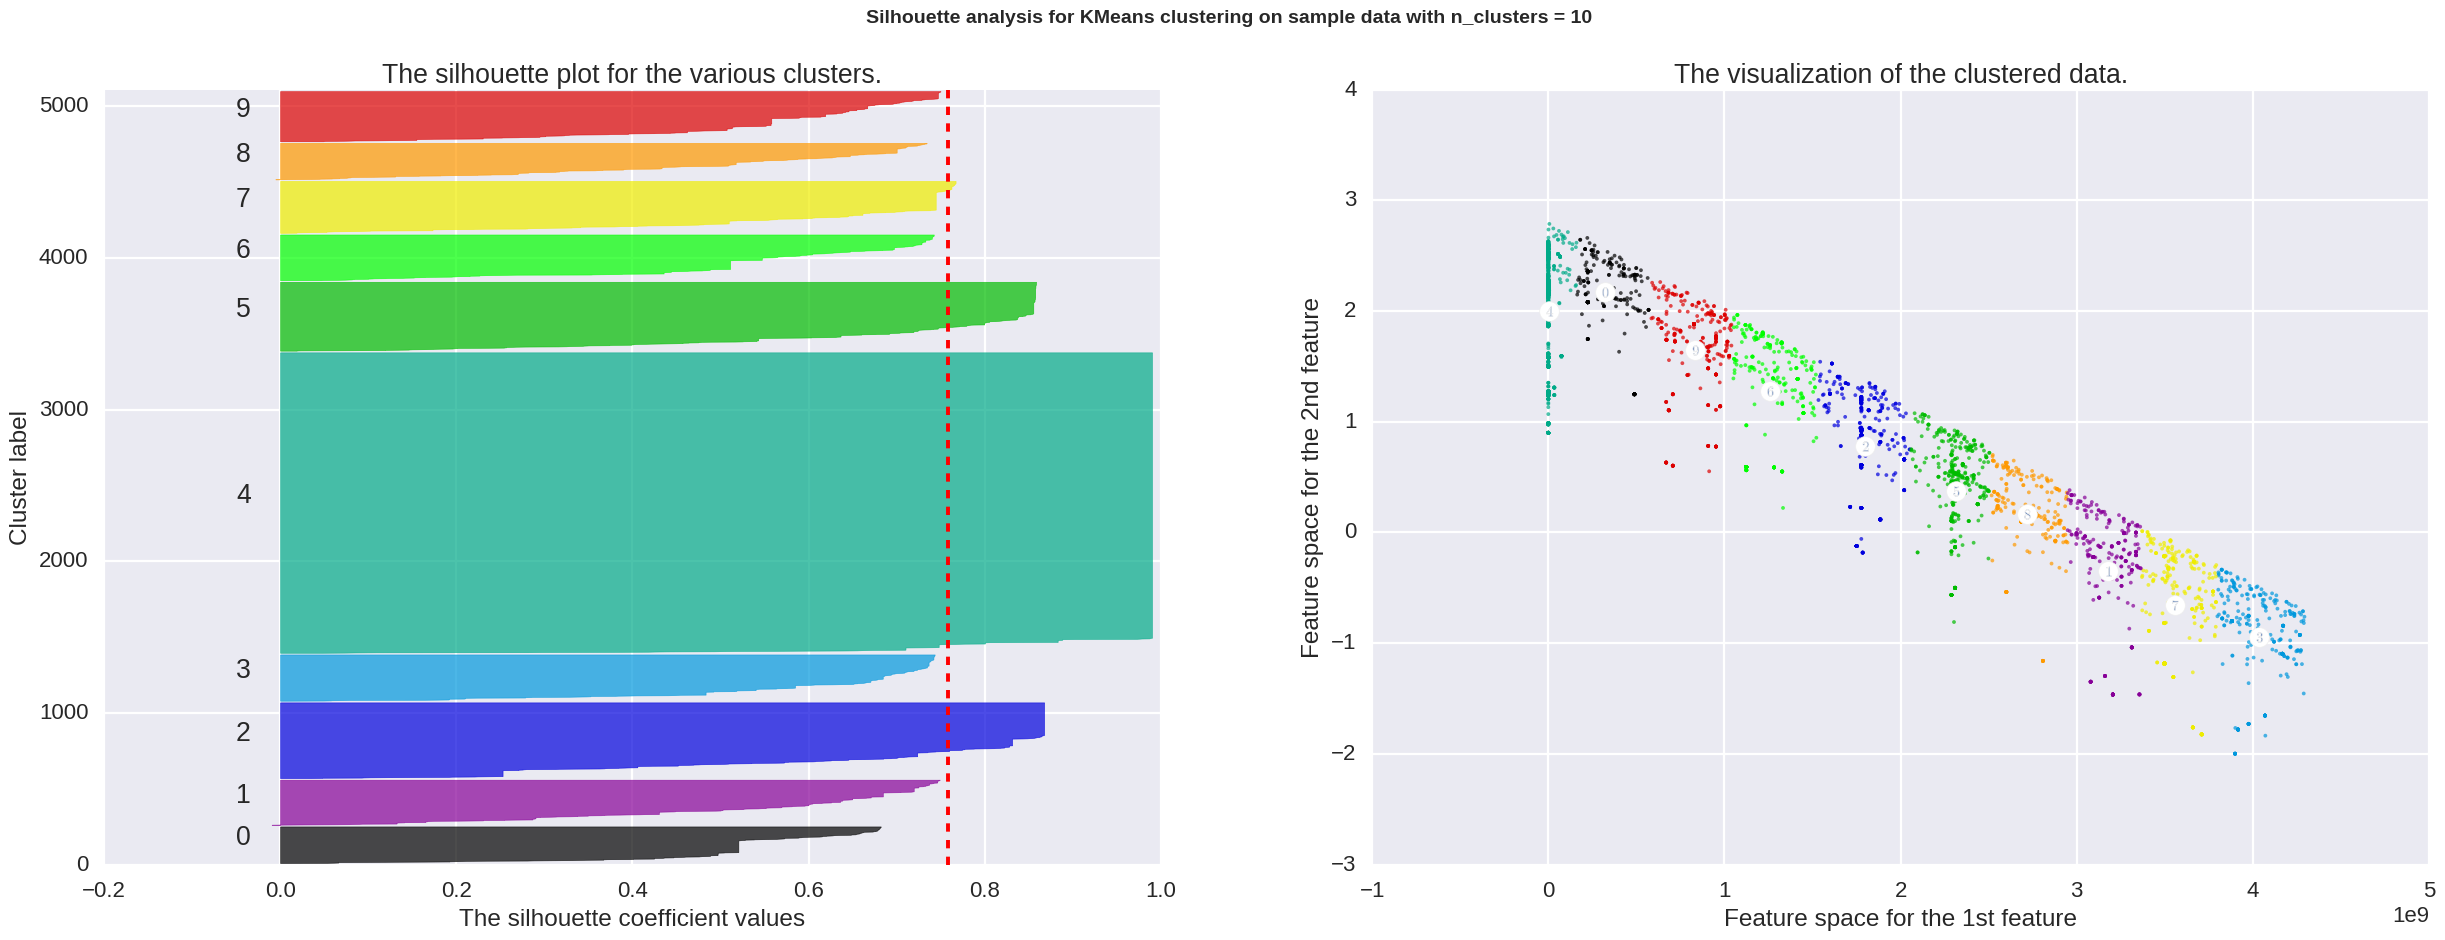

In [118]:
range_n_clusters = [3, 4, 5, 6,7,8,9,10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 10)
    
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(TSVD_2d) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(TSVD_2d)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(TSVD_2d, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(TSVD_2d, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(TSVD_2d[:, 0], TSVD_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

      cluster_label  \
0     1               
1     2               
2     0               
3     0               
4     0               
5     1               
6     0               
7     4               
8     1               
9     0               
10    4               
11    0               
12    4               
13    4               
14    4               
15    0               
16    0               
17    1               
18    0               
19    1               
20    5               
21    4               
22    0               
23    3               
24    0               
25    1               
26    1               
27    1               
28    2               
29    4               
...  ..               
4970  0               
4971  5               
4972  4               
4973  3               
4974  3               
4975  1               
4976  2               
4977  3               
4978  4               
4979  0               
4980  2               
4981  2    

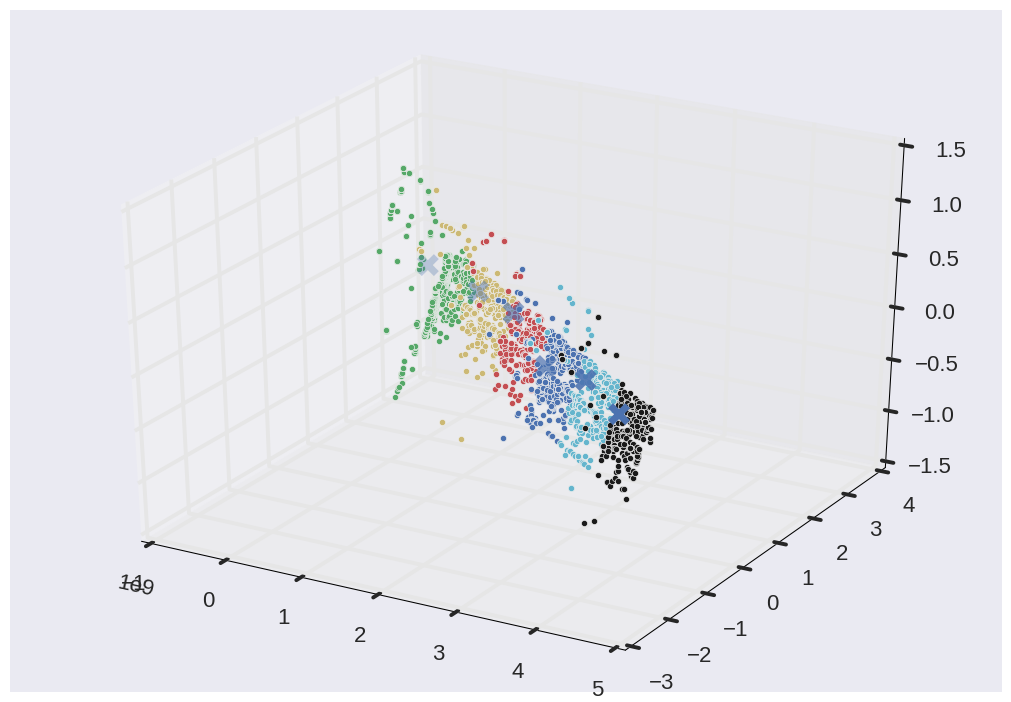

In [119]:
X = TSVD_3d
cluster_num =6

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

new_df_mal = pd.concat((pd.DataFrame(labels),sha_df_mal),axis=1).rename({}).rename(columns = {0:'cluster_label'})
print new_df_mal
color = ["g","r","c","y","b","k","m","w"]

# color = np.random.rand(cluster_num)

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')

for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
#     print "i : ",i
#     print "color[labels[i]] : ",color[labels[i]]
    ax.scatter(X[i][0], X[i][1], X[i][2], c=color[labels[i]])


for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], marker = "x", s=150, linewidths = 5, zorder = 100)

plt.show()

In [120]:
df_base_mal = pd.DataFrame(malicious_dataframe['sha256'].astype(str))

In [121]:
df_base_ben = pd.DataFrame(benign_dataframe['sha256'].astype(str))
# pd.merge(new_df_mal, df_base_mal, on='sha256', how='inner', suffixes=('_peinfo', '_opcode'))

In [122]:
df_pe_opcode = new_df_mal.set_index('sha256').join(df_base_mal.set_index('sha256'))


###  Clustering Peinfo(Benign)

In [123]:
TSVD_ben = TruncatedSVD(n_components=2).fit(total_textual_features_ben)
TSVD_3d_ben_alg = TruncatedSVD(n_components=3).fit(total_textual_features_ben)
TSVD_nd_ben_alg = TruncatedSVD(n_components=50).fit(total_textual_features_ben)

TSVD_2d_ben = TSVD_ben.transform(total_textual_features_ben)
TSVD_3d_ben = TSVD_3d_ben_alg.transform(total_textual_features_ben)
TSVD_nd_ben = TSVD_nd_ben_alg.transform(total_textual_features_ben)


[[  6.30564908e+08   2.22540036e+00  -9.44742457e-02]
 [  2.91196065e+09  -6.94188072e-02  -1.21577840e-01]
 [  2.34926235e+09   1.64179098e-01   2.40897110e-01]
 [  3.46918802e+09  -6.12814367e-01  -1.45441643e-01]
 [  1.22886621e+09   1.63037471e+00  -1.07665103e-01]
 [  4.03879347e+09  -1.18057655e+00  -1.55589528e-01]
 [  7.63924844e+07   1.97303827e+00   2.88410973e-01]
 [  1.81689268e+09   1.03977513e+00  -1.10627222e-01]]
Cluster 0 contains 433 samples
Cluster 1 contains 545 samples
Cluster 2 contains 1467 samples
Cluster 3 contains 397 samples
Cluster 4 contains 435 samples
Cluster 5 contains 407 samples
Cluster 6 contains 645 samples
Cluster 7 contains 425 samples


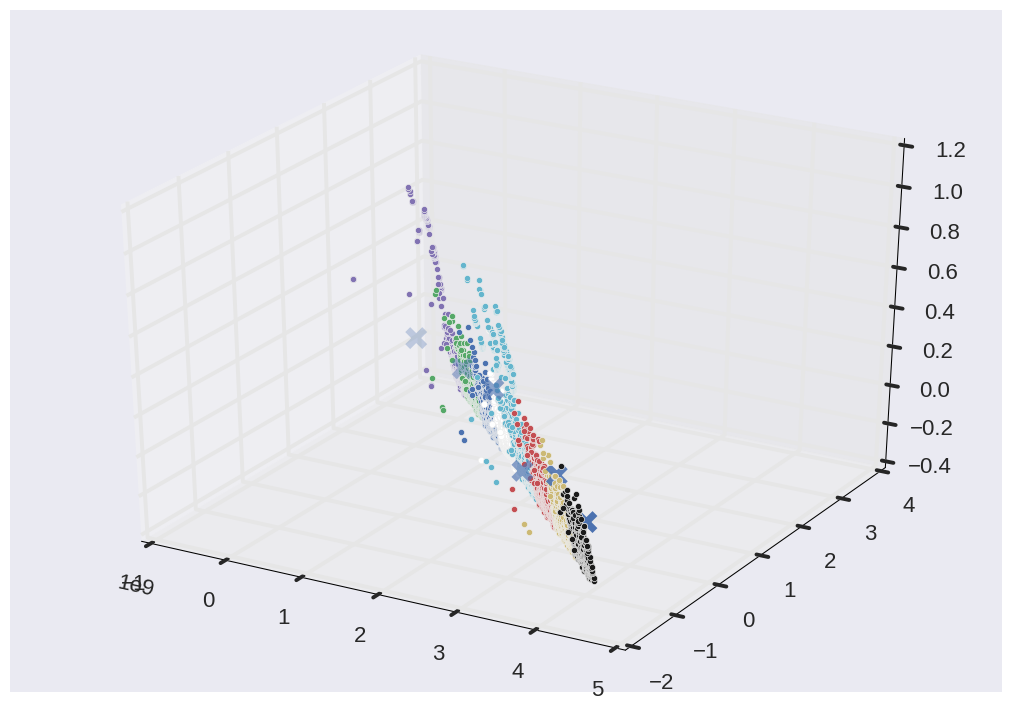

In [124]:
X = TSVD_3d_ben
cluster_num =8

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(X)

centroids_ben = kmeans.cluster_centers_
labels = kmeans.labels_

# print "centroids : "
# print centroids
# print "labels : "



new_df_ben = pd.concat((pd.DataFrame(labels),sha_df_benign),axis=1).rename({}).rename(columns = {0:'cluster_label'})
print centroids_ben
color = ["g","r","c","y","b","k","m","w"]

# color = np.random.rand(cluster_num)

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')

for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
#     print "i : ",i
#     print "color[labels[i]] : ",color[labels[i]]
    ax.scatter(X[i][0], X[i][1], X[i][2], c=color[labels[i]])


for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
#     print("Cluster {} has {} centroid".format(cluster_number, c[centroids_ben]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2],marker = "x", s=150, linewidths = 5, zorder = 100)

plt.show()

### Similarity (Unsupervised Nearest Neighbours)


#### Nearest Neighbors(BALL TREE)

In [125]:
# X = TSVD_3d_mopcode
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(TSVD_nd_mopcode)
distances, indices = nbrs.kneighbors(TSVD_pe_nd)

In [126]:
distances

array([[  1.77698878e+09],
       [  3.49778482e+09],
       [  1.67141838e+00],
       ..., 
       [  1.77698878e+09],
       [  2.50727290e+00],
       [  2.31233981e+00]])

In [127]:
pd.DataFrame(indices)[0].value_counts()

1       1793
1917    1618
1151    809 
2961    690 
3067    90  
Name: 0, dtype: int64

#### Nearest Neighbors(KDTree)

In [128]:
# # X = TSVD_3d_mopcode
# nbrs = NearestNeighbors(n_neighbors=1, algorithm = 'kd_tree').fit(TSVD_nd_mopcode)
# distances, indices = nbrs.kneighbors(TSVD_pe_nd)

kdt = KDTree(TSVD_nd_mopcode, leaf_size=30, metric='euclidean')
dist,indices = kdt.query(TSVD_pe_nd, k=1, return_distance=True) 

In [129]:
dist

array([[  1.77698878e+09],
       [  3.49778482e+09],
       [  1.67141838e+00],
       ..., 
       [  1.77698878e+09],
       [  2.50727290e+00],
       [  2.31233981e+00]])

In [130]:
pd.DataFrame(indices)[0].value_counts()

1151    2427
1       1793
2961    690 
3067    90  
Name: 0, dtype: int64

### Supervised Nearest Neighbours

#### Nearest Neighbors

In [131]:
X = TSVD_nd_mopcode
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X, new_df_mopcode['cluster_label'])
distances,indices = nbrs.kneighbors(TSVD_pe_nd)

In [132]:
pd.DataFrame(indices)[0].value_counts()

1       1793
1917    1618
1151    809 
2961    690 
3067    90  
Name: 0, dtype: int64

In [133]:
X = TSVD_nd_bopcode
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X, new_df_bopcode['cluster_label'])
distances,indices = nbrs.kneighbors(TSVD_nd_ben)

In [134]:
pd.DataFrame(indices)[0].value_counts()

3543    4417
3859    336 
3649    1   
Name: 0, dtype: int64

#### KNeighbors

In [135]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(TSVD_nd_mopcode, new_df_mopcode['cluster_label'])
distances, indices = neigh.kneighbors(TSVD_pe_nd)

In [136]:
pd.DataFrame(indices)[0].value_counts()

1151    2427
1       1793
2961    690 
3067    90  
Name: 0, dtype: int64

In [137]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(TSVD_nd_bopcode, new_df_bopcode['cluster_label'])
distances, indices = neigh.kneighbors(TSVD_nd_ben)

In [138]:
pd.DataFrame(indices)[0].value_counts()

3543    4417
3859    336 
3649    1   
Name: 0, dtype: int64

#### KDTree

In [139]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm = 'kd_tree').fit(TSVD_nd_mopcode, new_df_mopcode['cluster_label'])
distances, indices = nbrs.kneighbors(TSVD_pe_nd)

In [140]:
pd.DataFrame(indices)[0].value_counts()

1151    2427
1       1793
2961    690 
3067    90  
Name: 0, dtype: int64

In [141]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm = 'kd_tree').fit(TSVD_nd_bopcode, new_df_bopcode['cluster_label'])
distances, indices = nbrs.kneighbors(TSVD_nd_ben)

In [142]:
pd.DataFrame(indices)[0].value_counts()

3543    4417
3859    336 
3649    1   
Name: 0, dtype: int64

#### BallTree

In [143]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm = 'ball_tree').fit(TSVD_nd_mopcode, new_df_mopcode['cluster_label'])
distances, indices = nbrs.kneighbors(TSVD_pe_nd)

In [144]:
indices

array([[1151],
       [1917],
       [   1],
       ..., 
       [1151],
       [   1],
       [   1]])

In [145]:
pd.DataFrame(indices)[0].value_counts()

1       1793
1917    1618
1151    809 
2961    690 
3067    90  
Name: 0, dtype: int64

In [146]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm = 'ball_tree').fit(TSVD_nd_bopcode, new_df_bopcode['cluster_label'])
distances, indices = nbrs.kneighbors(TSVD_nd_ben)

In [147]:
pd.DataFrame(indices)[0].value_counts()

3543    4417
3859    336 
3649    1   
Name: 0, dtype: int64

#### NearestCentroid

In [148]:
clf = NearestCentroid().fit(TSVD_nd_mopcode, new_df_mopcode['cluster_label'])
cluster = (clf.predict(TSVD_pe_nd))

In [149]:
pd.DataFrame(cluster)[0].value_counts()

0    3117
4    1883
Name: 0, dtype: int64

In [150]:
clf = NearestCentroid().fit(TSVD_nd_bopcode, new_df_bopcode['cluster_label'])
cluster = (clf.predict(TSVD_nd_ben))

In [151]:
pd.DataFrame(cluster)[0].value_counts()

0    4417
3    337 
Name: 0, dtype: int64

#### LSH

In [152]:
lshf = LSHForest(random_state=0).fit(TSVD_nd_mopcode)  
distances, indices = lshf.kneighbors(TSVD_pe_nd, n_neighbors=1)


In [153]:
distances

array([[  1.98295547e-09],
       [  1.98289707e-09],
       [  2.74566896e-01],
       ..., 
       [  1.98294281e-09],
       [  5.28994788e-01],
       [  8.94664288e-01]])

In [154]:
indices

array([[1673],
       [1673],
       [ 273],
       ..., 
       [1673],
       [1319],
       [ 121]])

In [155]:
pd.DataFrame(indices)[0].value_counts()

1673    3117
2304    536 
121     255 
1319    100 
1534    91  
507     76  
2161    75  
2232    72  
273     65  
291     62  
1246    60  
3067    56  
1789    55  
1194    54  
2614    51  
1808    50  
1230    48  
3150    41  
2089    37  
3274    31  
185     29  
187     25  
1093    7   
1619    6   
1397    1   
Name: 0, dtype: int64

### LSH (Locality Sensitive Hashing gives the candidates for similar malware which are almost equal to peinfo clustered ) Ball Tree ,KDTree , Nearest Neighbor & NearestCentroid provide only three cluster labels and the result of these algorithms are same